<a href="https://colab.research.google.com/github/joanvelja/joanvelja/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment N°1 - Joan Velja - 24652164**
This assessment requires you to develop two different classifiers namely: SVM and Neural Network (ANN) for handwritten mathematical symbol classification.
The features to be used for classification are: Histogram-Of-Oriented-Gradients (HoG), Local Binary Pattern (LBP), Raw images/pixels, Any other feature (optional).

### **Step 1) Importing all the necessary libraries**
We will import two separate sets of libraries: the first one being sklearn for the SVM classifier and the second one being tensorflow for the ANN. Along with those, we will also import standard libraries for Machine Learning tasks such as numpy, os and others.

In [ ]:
import os
import numpy as np
import cv2 
import random   
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tensorflow.keras import regularizers

#%load_ext autotime


import tensorflow as tf
from sklearn import svm


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


%load_ext tensorboard

In [ ]:
#%unload_ext autotime

### **Step 2) Importing the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/42028/assignment1/dataset_42028assg1_24652164

/content/gdrive/MyDrive/42028/assignment1/dataset_42028assg1_24652164




---



### **Step 0) creation of various functions:**

*   `evaluator` yields a confusion matrix along with the accuracy, given the predicted `y` and `y_test`;
*   `gaussianizer` applies a Gauss kernel (filter) to the image, which is believed in academia to help edge detection algorithms/models;
*    `data_loader`, as the title suggests, loads the data from the directory;



In [ ]:
def evaluator(test_y,
              y_pred,
              labels = ["0", "1", "2", "3"],
              normalize = True,
              runtime = None):
    plt.figure(figsize = (10,7))
    print(classification_report(test_y,y_pred))
    cm = confusion_matrix(test_y, y_pred)
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        cmat = pd.DataFrame(cm)
    else:
        cmat = pd.DataFrame(cm)
    cmat.columns = labels
    plt.title("Confusion Matrix")
    if runtime is None:
        sns.heatmap(cmat, cmap="coolwarm_r", annot=True).set_ylabel("True label")
        plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    else:
        sns.heatmap(cmat, cmap="coolwarm_r", annot=True).set_ylabel("True label")
        plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; runtime={:0.4f} sec.'.format(accuracy, misclass,runtime))
    plt.show()
    
    return cm

In [ ]:
def data_loader():
  root = "/content/gdrive/MyDrive/42028/assignment1/dataset_42028assg1_24652164"
  os.chdir(root)
  subdirs = [d for d in os.listdir(root) if not d.startswith('.')]
  X, y = [], []

  for d in subdirs:
    print(f"d = {d} , type = {type(d)}")
    path = os.path.join(root, d)
    os.chdir(path)
    files = os.listdir()
    suby = [d for _ in range(len(files))]
    subX = []
    for f in files:
      img=cv2.imread(os.path.join(path, f), cv2.IMREAD_GRAYSCALE)
      #resized_img = resize(img, (128, 64))
      subX.append(img)
    
    X.append(subX)
    y.append(suby)

  
  return X,y

In [ ]:
def gaussianizer(data):
  processed = []
  for i in data:
    gaussian_blur = cv2.GaussianBlur(src=i, ksize=(5,5), sigmaX = 0)
    processed.append(gaussian_blur)
  
  return np.array(processed)


In [ ]:
X,y = data_loader()

d = pm , type = <class 'str'>
d = leq , type = <class 'str'>
d = ] , type = <class 'str'>
d = times , type = <class 'str'>
d = + , type = <class 'str'>
d = pi , type = <class 'str'>
d = div , type = <class 'str'>
d = neq , type = <class 'str'>
d = [ , type = <class 'str'>
d = = , type = <class 'str'>


Sanity check: making sure there is no imbalance in the classes (i.e., labels being over represented).

In [ ]:
X = [item for sublist in X for item in sublist]
y = [item for sublist in y for item in sublist]

In [ ]:
Counter(y)

Counter({'pm': 500,
         'leq': 500,
         ']': 500,
         'times': 500,
         '+': 500,
         'pi': 500,
         'div': 500,
         'neq': 500,
         '[': 500,
         '=': 500})

Since each symbol has 500 samples, the dataset is perfectly balanced and thus doesn't require stratification.

A further check is carried out to ensure the size of the images:

In [ ]:
px,py = X[1].shape
px,py

(45, 45)

And here I am encoding the features into scalar values.

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y)
list(le.classes_)

['+', '=', '[', ']', 'div', 'leq', 'neq', 'pi', 'pm', 'times']

In [ ]:
y = le.transform(y)
y

array([8, 8, 8, ..., 1, 1, 1])

Here I splitted the data into **training, testing and validation** using the 70/20/10 rule as suggested. I was able to achieve the splitting through a 2-fold usage of `sklearn`'s `train_test_split` function.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.125, shuffle=True, random_state = 42)

In [ ]:
X_train, X_test, X_val = np.array(X_train), np.array(X_test), np.array(X_val)

Normalization of the pixels, for an easier calculation.

In [ ]:
X_train, X_test, X_val = X_train / 255.0, X_test / 255.0, X_val / 255.0

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((3500, 45, 45), (1000, 45, 45), (500, 45, 45))

This is a crucial part. I am building all the splits that I will use at later stages:

1.   `X_train`,`X_test`, `X_val` will be the three splits of *raw data/pixels*.
  *   `X_train_Gauss`,`X_test_Gauss`, `X_val_Gauss` will be the three splits of *raw data/pixels* **blurred**.
  

2.   `X_train_HOG`, `X_test_HOG`, `X_val_HOG` will be the three splits of *HOG* processed data.
  *   `X_train_HOG_Gauss`,`X_test_HOG_Gauss`, `X_val_HOG_Gauss` will be the three splits of *HOG* processed data **blurred**.
  
3.   `X_train_LBP`, `X_test_LBP`, `X_val_LBP` will be the three splits of *LBP* processed data.
  *   `X_train_LBP_Gauss`,`X_test_LBP_Gauss`, `X_val_LBP_Gauss` will be the three splits of *LBP* processed data **blurred**.
 
4. `X_train_Gabor`, `X_test_Gabor`, `X_val_Gabor` will be the three splits of *Gabor* processed data.
  * `X_train_Gabor_Gauss`, `X_test_Gabor_Gauss`, `X_val_Gabor_Gauss`, will be the three splits of *Gabor* processed data **blurred**.

In [ ]:
X_train_Gauss, X_test_Gauss, X_val_Gauss = gaussianizer(X_train), gaussianizer(X_test), gaussianizer(X_val)

### **Step 3) HOG feature extraction**

In [ ]:
from skimage.transform import resize
from skimage.feature import hog

In [ ]:
def hog_extractor(data):
  processed = []
  for i in data:
    hog_image = hog(i, orientations=9, pixels_per_cell=(9, 9),
                    cells_per_block=(3, 3))
    
    processed.append(hog_image)

  return np.array(processed)


In [ ]:
X_train_HOG, X_val_HOG, X_test_HOG = hog_extractor(X_train), hog_extractor(X_val), hog_extractor(X_test)
X_train_HOG_Gauss, X_val_HOG_Gauss, X_test_HOG_Gauss = hog_extractor(X_train_Gauss), hog_extractor(X_val_Gauss), hog_extractor(X_test_Gauss)

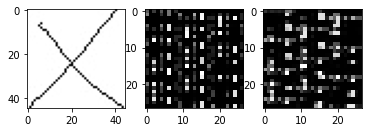

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.subplots_adjust(hspace=0.5)

length = int(np.sqrt(X_train_HOG_Gauss[0].shape[0]))

ax1.imshow(X_train[0], cmap = 'gray')
ax2.imshow(X_train_HOG[0].reshape(length,length), cmap ='gray')
ax3.imshow(X_train_HOG_Gauss[0].reshape(length,length), cmap ='gray')

### **Step 4) LBP feature extraction**

In [ ]:
from skimage.feature import local_binary_pattern

In [ ]:
def lbp_extractor(data, n_points = 8, radius = 1, method = "uniform"):
  processed = []
  for i in data:
    lbp_image = local_binary_pattern(i, n_points, radius, method)
    processed.append(lbp_image)

  return np.array(processed)

In [ ]:
X_train_LBP, X_val_LBP, X_test_LBP = lbp_extractor(X_train), lbp_extractor(X_val), lbp_extractor(X_test)
X_train_LBP_Gauss, X_val_LBP_Gauss, X_test_LBP_Gauss = lbp_extractor(X_train_Gauss), lbp_extractor(X_val_Gauss), lbp_extractor(X_test_Gauss)

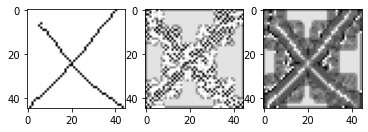

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.subplots_adjust(hspace=0.5)

length = int(np.sqrt(X_train_LBP_Gauss[0].shape[0]))

ax1.imshow(X_train[0], cmap = 'gray')
ax2.imshow(X_train_LBP[0].reshape(45,45), cmap ='gray')
ax3.imshow(X_train_LBP_Gauss[0].reshape(45,45), cmap ='gray')

### **Step 5) Gabor feature extraction**

In [ ]:
from skimage.filters import gabor

In [ ]:
def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 16
    ksize = 9  # The local area to evaluate
    sigma = 5.0  # Larger Values produce more edges
    lambd = 50.0
    gamma = 0.5
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

In [ ]:
def apply_filter(data, filters):
# This general function is designed to apply filters to our image
    processed = [] 
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(data[0])
     
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
    for img in data: 
      for kern in filters:  # Loop through the kernels in our GaborFilter
          image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
          #plt.imshow(image_filter)
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
          #np.maximum(newimage, image_filter, newimage)
      processed.append(image_filter)
    return np.array(processed)

In [ ]:
gfilters = create_gaborfilter()
X_train_Gabor, X_val_Gabor, X_test_Gabor = apply_filter(X_train, gfilters), apply_filter(X_val, gfilters), apply_filter(X_test, gfilters)
X_train_Gabor_Gauss, X_val_Gabor_Gauss, X_test_Gabor_Gauss = apply_filter(X_train_Gauss, gfilters), apply_filter(X_val_Gauss, gfilters), apply_filter(X_test_Gauss, gfilters)

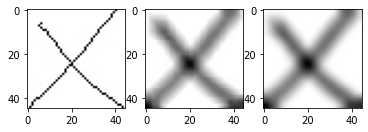

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.subplots_adjust(hspace=0.5)

length = int(np.sqrt(X_train_LBP_Gauss[0].shape[0]))

ax1.imshow(X_train[0], cmap = 'gray')
ax2.imshow(X_train_Gabor[0].reshape(45,45), cmap ='gray')
ax3.imshow(X_train_Gabor_Gauss[0].reshape(45,45), cmap ='gray')

### **Step 6) Evaluation**

##### **SVM - Raw Pixel, non gaussed**

In [ ]:
model = svm.SVC(kernel='rbf',C=10.0, random_state=42)

Since SVM requires <=2 dimensional arrays, we need to reshape the train/test sets.

In [ ]:
nsamples, nx, ny = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny))
test_nsamples, nx, ny = X_test.shape
d2_X_test = X_test.reshape((test_nsamples,nx*ny))

In [ ]:
#%load_ext autotime

In [ ]:
model.fit(d2_X_train, y_train)
print("Train set Accuracy: {:.2f}".format(model.score(d2_X_train,y_train)))


ypred = model.predict(d2_X_test)


accuracy = metrics.accuracy_score(y_test, ypred)
print("Accuracy on test dataset:",accuracy)

Train set Accuracy: 1.00
Accuracy on test dataset: 0.974


              precision    recall  f1-score   support

           0       0.90      0.96      0.93        94
           1       0.98      0.95      0.96       111
           2       1.00      1.00      1.00        81
           3       1.00      1.00      1.00       105
           4       1.00      0.97      0.98        98
           5       0.96      1.00      0.98       105
           6       1.00      1.00      1.00       112
           7       0.95      0.92      0.93        98
           8       1.00      0.99      1.00       111
           9       0.94      0.95      0.95        85

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



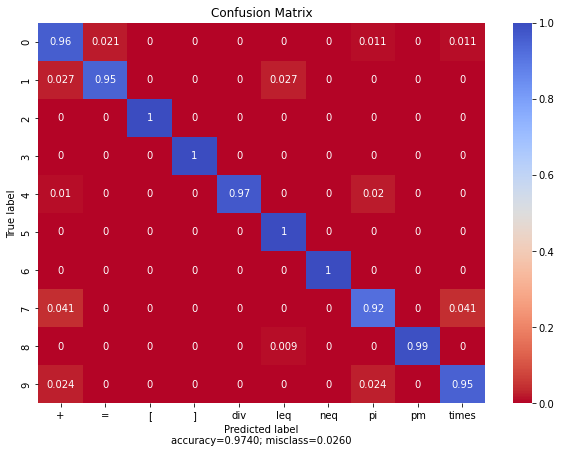

In [ ]:
cm1 = evaluator(y_test, ypred, labels = list(le.classes_))

In [ ]:
#%unload_ext autotime

Predicted label = ['+'], expected label = ['div']


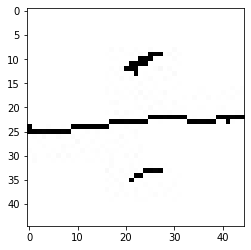

Predicted label = ['leq'], expected label = ['=']


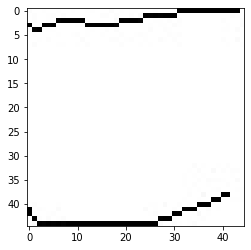

Predicted label = ['times'], expected label = ['pi']


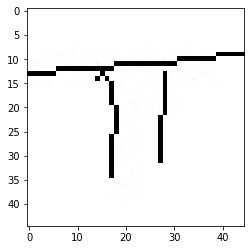

Predicted label = ['+'], expected label = ['pi']


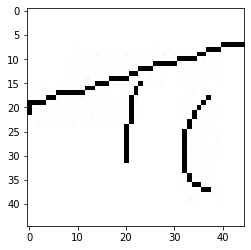

Predicted label = ['='], expected label = ['+']


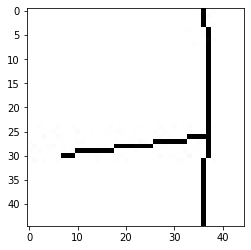

Predicted label = ['leq'], expected label = ['=']


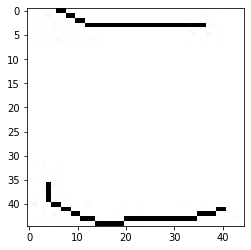

Predicted label = ['+'], expected label = ['=']


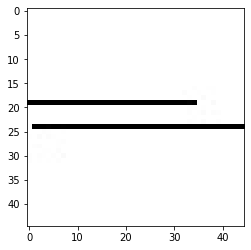

Predicted label = ['pi'], expected label = ['times']


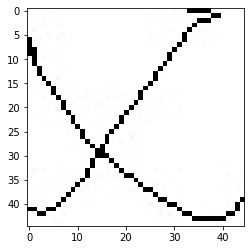

Predicted label = ['+'], expected label = ['pi']


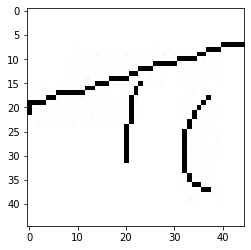

Predicted label = ['+'], expected label = ['pi']


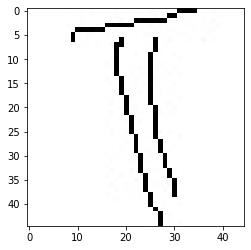

Predicted label = ['times'], expected label = ['pi']


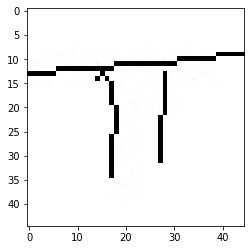

Predicted label = ['+'], expected label = ['times']


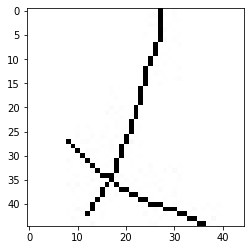

Predicted label = ['leq'], expected label = ['=']


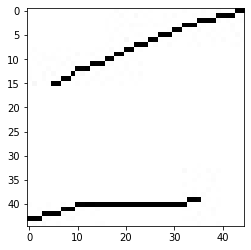

Predicted label = ['pi'], expected label = ['div']


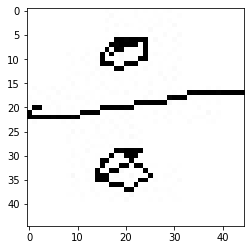

Predicted label = ['+'], expected label = ['=']


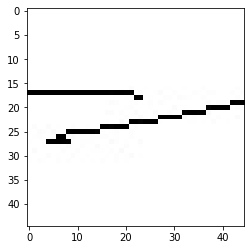

Predicted label = ['times'], expected label = ['pi']


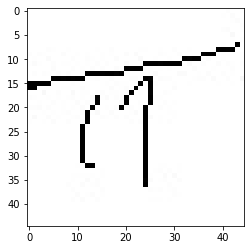

Predicted label = ['+'], expected label = ['pi']


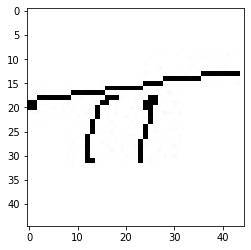

Predicted label = ['pi'], expected label = ['+']


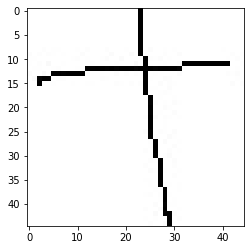

Predicted label = ['='], expected label = ['+']


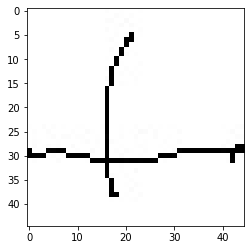

Predicted label = ['pi'], expected label = ['div']


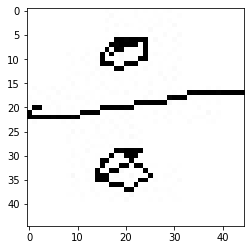

Predicted label = ['times'], expected label = ['pi']


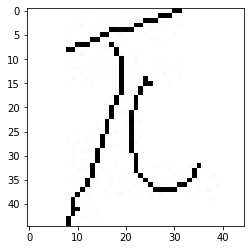

Predicted label = ['times'], expected label = ['+']


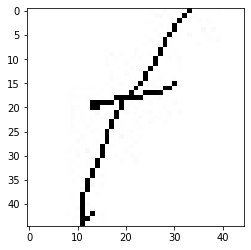

Predicted label = ['pi'], expected label = ['times']


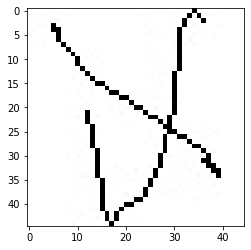

Predicted label = ['+'], expected label = ['=']


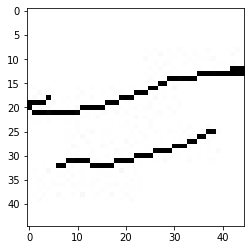

Predicted label = ['+'], expected label = ['times']


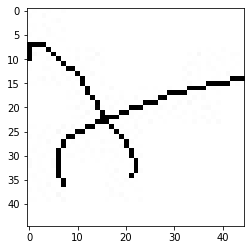

Predicted label = ['leq'], expected label = ['pm']


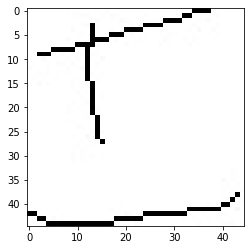

# of misclassificated images = 26


In [ ]:
count = 0
for j in range (len(ypred)):
  if ypred[j] != y_test[j]:
    print(f"Predicted label = {le.inverse_transform([ypred[j]])}, expected label = {le.inverse_transform([y_test[j]])}")
    count += 1
    plt.imshow(X_test[j], cmap = 'gray')
    plt.show()

print(f"# of misclassificated images = {count}")

##### **SVM - Raw Pixel, gaussed**

In [ ]:
model = svm.SVC(kernel='rbf',C=10.0, random_state=42)

Since SVM requires <=2 dimensional arrays, we need to reshape the train/test sets.

In [ ]:
nsamples, nx, ny = X_train.shape
d2_X_train_Gauss = X_train_Gauss.reshape((nsamples,nx*ny))
test_nsamples, nx, ny = X_test.shape
d2_X_test_Gauss = X_test_Gauss.reshape((test_nsamples,nx*ny))

In [ ]:
#%load_ext autotime

In [ ]:
model.fit(d2_X_train_Gauss, y_train)
print("Train set Accuracy: {:.2f}".format(model.score(d2_X_train_Gauss,y_train)))

ypred = model.predict(d2_X_test_Gauss)

accuracy = metrics.accuracy_score(y_test, ypred)
print("Accuracy on test dataset:",accuracy)

Train set Accuracy: 1.00
Accuracy on test dataset: 0.986


              precision    recall  f1-score   support

           0       0.93      0.97      0.95        94
           1       0.98      0.97      0.98       111
           2       1.00      1.00      1.00        81
           3       1.00      1.00      1.00       105
           4       0.99      0.99      0.99        98
           5       0.98      1.00      0.99       105
           6       1.00      1.00      1.00       112
           7       1.00      0.97      0.98        98
           8       1.00      0.99      1.00       111
           9       0.98      0.96      0.97        85

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



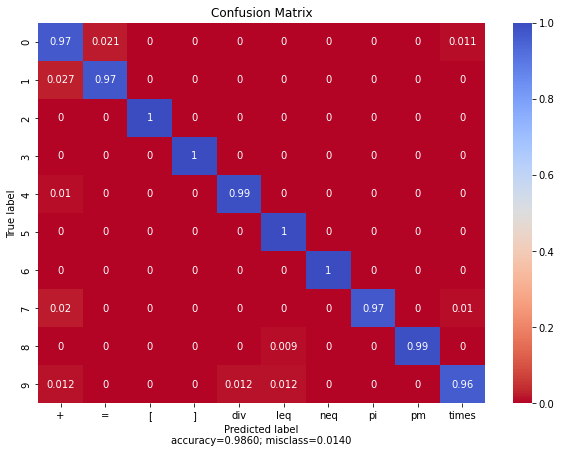

In [ ]:
cm1 = evaluator(y_test, ypred, labels = list(le.classes_))

In [ ]:
#%unload_ext autotime

Predicted label = ['+'], expected label = ['div']


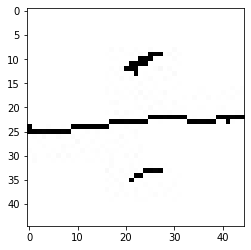

Predicted label = ['='], expected label = ['+']


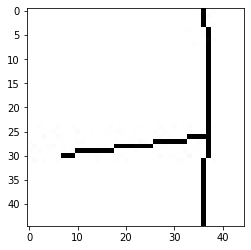

Predicted label = ['+'], expected label = ['=']


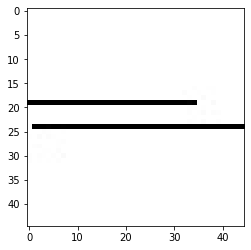

Predicted label = ['+'], expected label = ['pi']


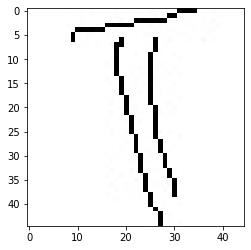

Predicted label = ['div'], expected label = ['times']


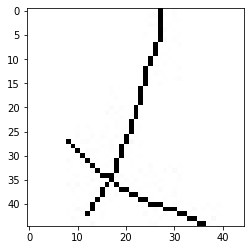

Predicted label = ['+'], expected label = ['=']


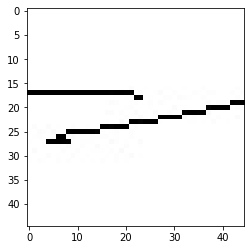

Predicted label = ['+'], expected label = ['pi']


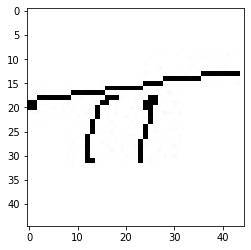

Predicted label = ['='], expected label = ['+']


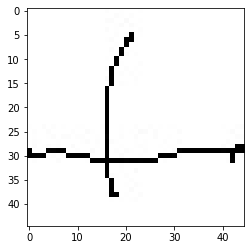

Predicted label = ['times'], expected label = ['pi']


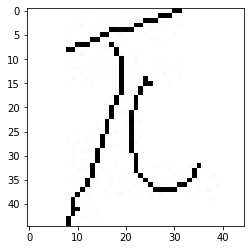

Predicted label = ['times'], expected label = ['+']


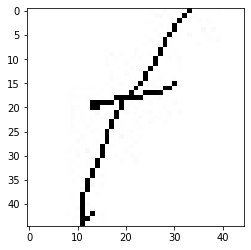

Predicted label = ['leq'], expected label = ['times']


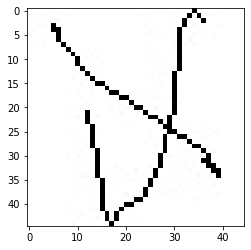

Predicted label = ['+'], expected label = ['=']


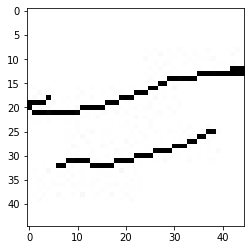

Predicted label = ['+'], expected label = ['times']


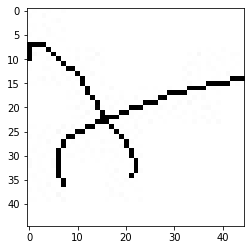

Predicted label = ['leq'], expected label = ['pm']


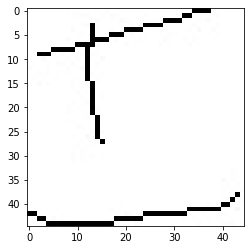

# of misclassificated images = 14


In [ ]:
count = 0
for j in range (len(ypred)):
  if ypred[j] != y_test[j]:
    print(f"Predicted label = {le.inverse_transform([ypred[j]])}, expected label = {le.inverse_transform([y_test[j]])}")
    count += 1
    plt.imshow(X_test[j], cmap = 'gray')
    plt.show()

print(f"# of misclassificated images = {count}")

##### **SVM - LBP, non gaussed**

In [ ]:
model = svm.SVC(kernel='rbf',C=10.0, random_state=42) # rbf Kernel
nsamples, nx, ny = X_train_LBP.shape
d2_X_train_LBP = X_train_LBP.reshape((nsamples,nx*ny))
test_nsamples, nx, ny = X_test.shape
d2_X_test_LBP = X_test_LBP.reshape((test_nsamples,nx*ny))

In [ ]:
#%load_ext autotime

In [ ]:
model = svm.SVC(kernel='rbf',C=10.0, random_state=42) # rbf Kernel
model.fit(d2_X_train_LBP, y_train)
print("Train set Accuracy: {:.2f}".format(model.score(d2_X_train_LBP,y_train)))

ypred = model.predict(d2_X_test_LBP)

accuracy = metrics.accuracy_score(y_test, ypred)
print("Accuracy on test dataset:",accuracy)

Train set Accuracy: 1.00
Accuracy on test dataset: 0.957


              precision    recall  f1-score   support

           0       0.89      0.88      0.89        94
           1       0.96      0.93      0.94       111
           2       0.99      1.00      0.99        81
           3       0.99      1.00      1.00       105
           4       0.98      0.94      0.96        98
           5       0.96      0.99      0.98       105
           6       0.96      0.97      0.97       112
           7       0.95      0.92      0.93        98
           8       0.99      0.99      0.99       111
           9       0.88      0.94      0.91        85

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



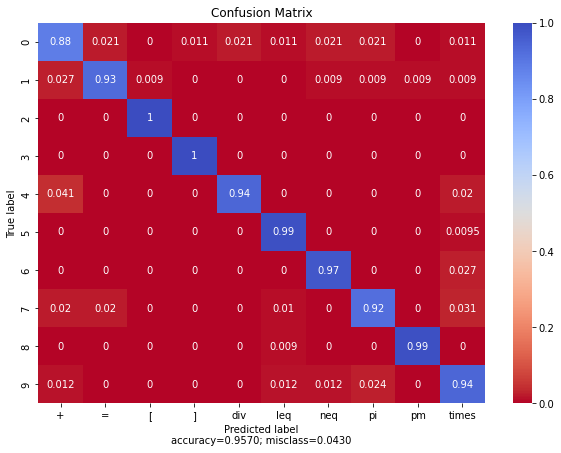

In [ ]:
cm1 = evaluator(y_test, ypred, labels = list(le.classes_))

In [ ]:
#%unload_ext autotime

Predicted label = ['times'], expected label = ['pi']


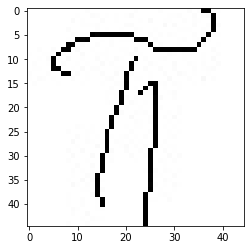

Predicted label = ['times'], expected label = ['leq']


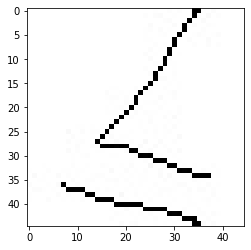

Predicted label = ['+'], expected label = ['div']


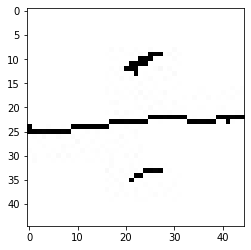

Predicted label = [']'], expected label = ['+']


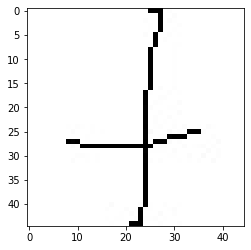

Predicted label = ['leq'], expected label = ['pi']


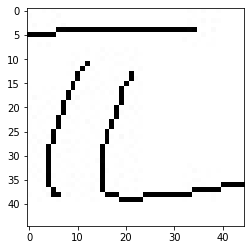

Predicted label = ['='], expected label = ['pi']


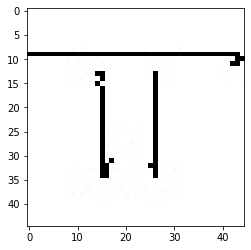

Predicted label = ['['], expected label = ['=']


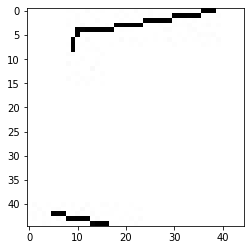

Predicted label = ['='], expected label = ['+']


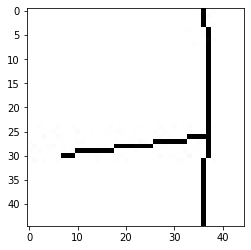

Predicted label = ['+'], expected label = ['div']


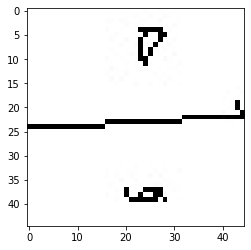

Predicted label = ['times'], expected label = ['pi']


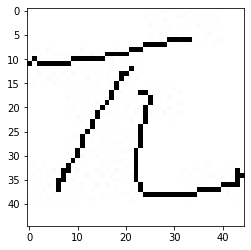

Predicted label = ['times'], expected label = ['pi']


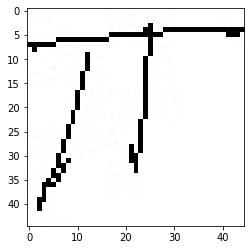

Predicted label = ['pi'], expected label = ['times']


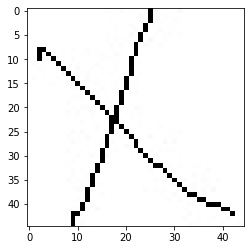

Predicted label = ['times'], expected label = ['neq']


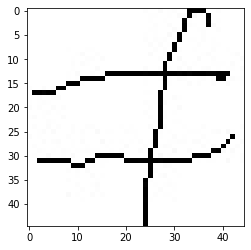

Predicted label = ['div'], expected label = ['+']


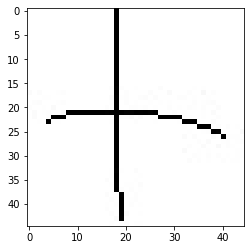

Predicted label = ['times'], expected label = ['neq']


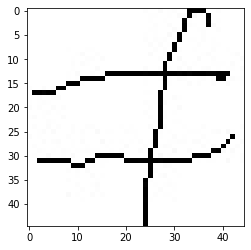

Predicted label = ['pi'], expected label = ['+']


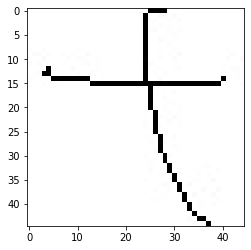

Predicted label = ['neq'], expected label = ['+']


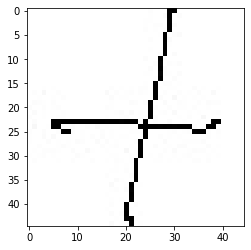

Predicted label = ['div'], expected label = ['+']


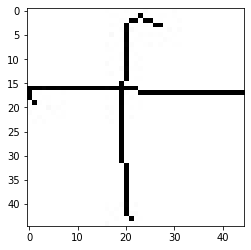

Predicted label = ['pi'], expected label = ['times']


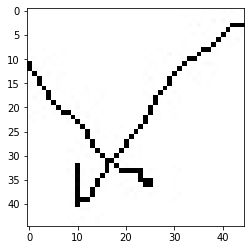

Predicted label = ['+'], expected label = ['=']


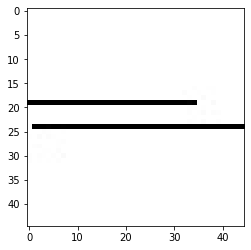

Predicted label = ['='], expected label = ['+']


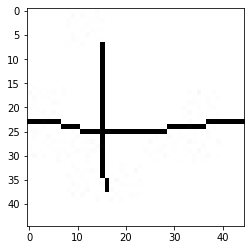

Predicted label = ['leq'], expected label = ['times']


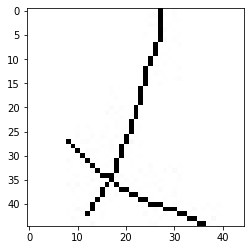

Predicted label = ['pm'], expected label = ['=']


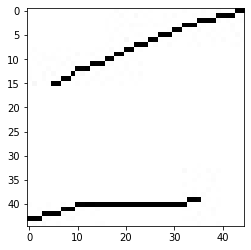

Predicted label = ['+'], expected label = ['pi']


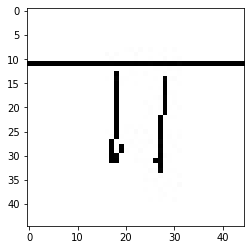

Predicted label = ['times'], expected label = ['div']


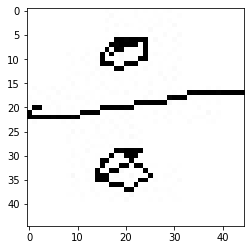

Predicted label = ['+'], expected label = ['=']


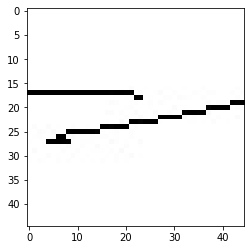

Predicted label = ['neq'], expected label = ['times']


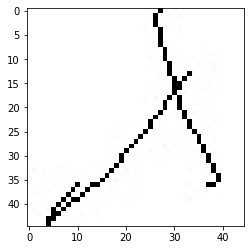

Predicted label = ['leq'], expected label = ['+']


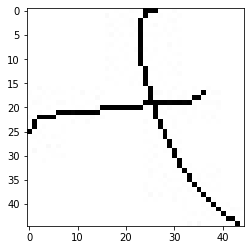

Predicted label = ['+'], expected label = ['pi']


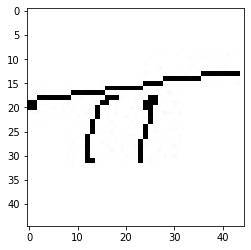

Predicted label = ['pi'], expected label = ['+']


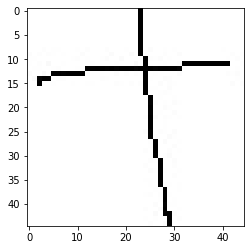

Predicted label = ['times'], expected label = ['div']


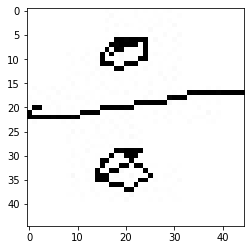

Predicted label = ['neq'], expected label = ['+']


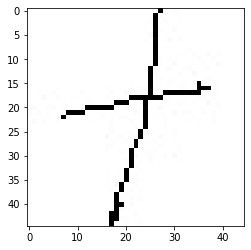

Predicted label = ['pi'], expected label = ['=']


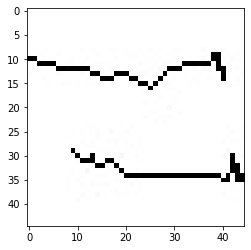

Predicted label = ['times'], expected label = ['+']


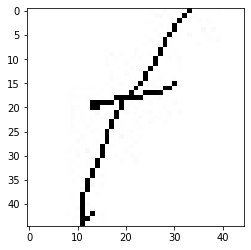

Predicted label = ['='], expected label = ['pi']


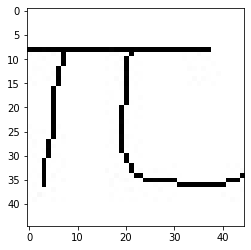

Predicted label = ['+'], expected label = ['div']


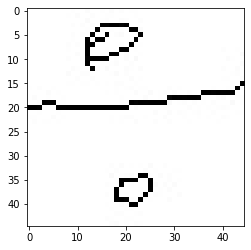

Predicted label = ['+'], expected label = ['div']


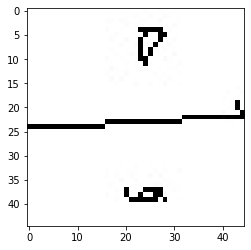

Predicted label = ['times'], expected label = ['=']


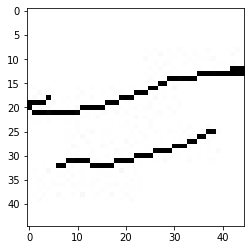

Predicted label = ['+'], expected label = ['times']


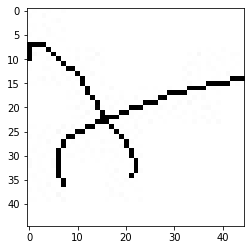

Predicted label = ['times'], expected label = ['neq']


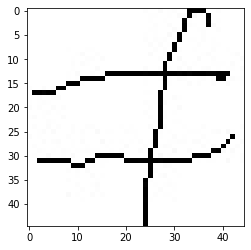

Predicted label = ['leq'], expected label = ['pm']


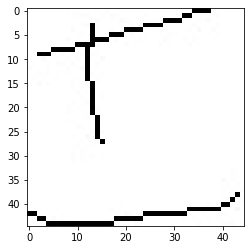

Predicted label = ['+'], expected label = ['=']


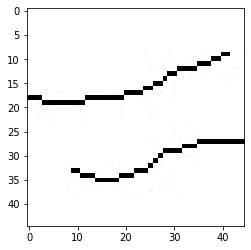

Predicted label = ['neq'], expected label = ['=']


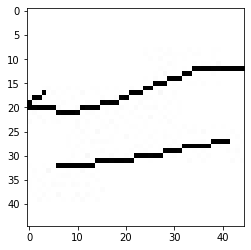

# of misclassificated images = 43


In [ ]:
count = 0
for j in range (len(ypred)):
  if ypred[j] != y_test[j]:
    print(f"Predicted label = {le.inverse_transform([ypred[j]])}, expected label = {le.inverse_transform([y_test[j]])}")
    count += 1
    plt.imshow(X_test[j], cmap='gray')
    plt.show()

print(f"# of misclassificated images = {count}")

##### **SVM - LBP, gaussed**

In [ ]:
model = svm.SVC(kernel='rbf',C=10.0, random_state=42) # rbf Kernel
nsamples, nx, ny = X_train_LBP_Gauss.shape
d2_X_train_LBP_Gauss = X_train_LBP_Gauss.reshape((nsamples,nx*ny))
test_nsamples, nx, ny = X_test_LBP_Gauss.shape
d2_X_test_LBP_Gauss = X_test_LBP_Gauss.reshape((test_nsamples,nx*ny))

In [ ]:
#%load_ext autotime

In [ ]:
model.fit(d2_X_train_LBP_Gauss, y_train)
print("Train set Accuracy: {:.2f}".format(model.score(d2_X_train_LBP_Gauss,y_train)))

ypred = model.predict(d2_X_test_LBP_Gauss)

accuracy = metrics.accuracy_score(y_test, ypred)
print("Accuracy on test dataset:",accuracy)

Train set Accuracy: 1.00
Accuracy on test dataset: 0.978


              precision    recall  f1-score   support

           0       0.97      0.94      0.95        94
           1       0.99      0.97      0.98       111
           2       0.98      1.00      0.99        81
           3       1.00      1.00      1.00       105
           4       0.99      0.97      0.98        98
           5       0.97      1.00      0.99       105
           6       0.95      1.00      0.97       112
           7       1.00      0.92      0.96        98
           8       0.99      0.99      0.99       111
           9       0.94      0.99      0.97        85

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



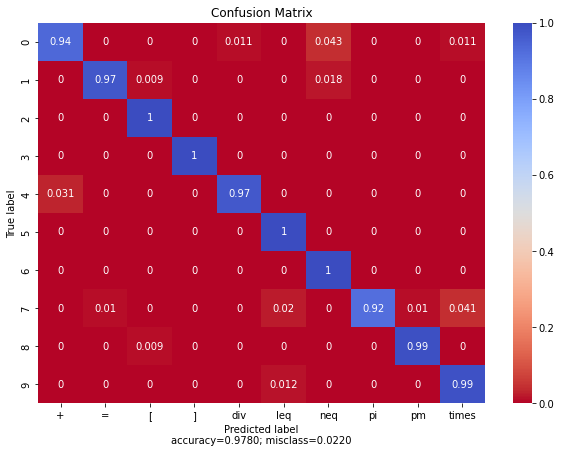

In [ ]:
cm1 = evaluator(y_test, ypred, labels = list(le.classes_))

Predicted label = ['+'], expected label = ['div']


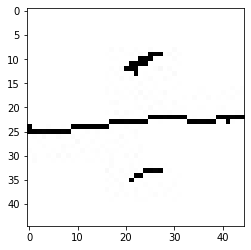

Predicted label = ['div'], expected label = ['+']


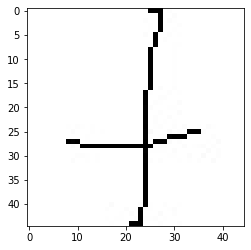

Predicted label = ['leq'], expected label = ['pi']


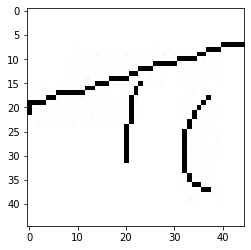

Predicted label = ['='], expected label = ['pi']


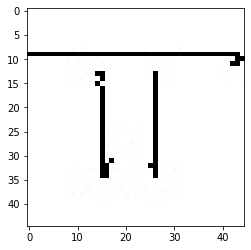

Predicted label = ['['], expected label = ['=']


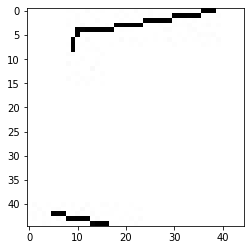

Predicted label = ['neq'], expected label = ['+']


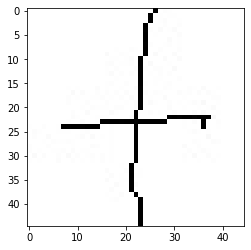

Predicted label = ['times'], expected label = ['pi']


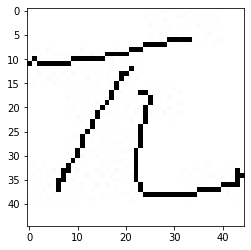

Predicted label = ['+'], expected label = ['div']


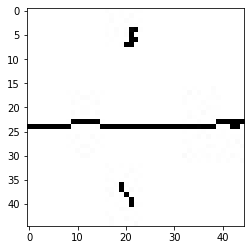

Predicted label = ['times'], expected label = ['pi']


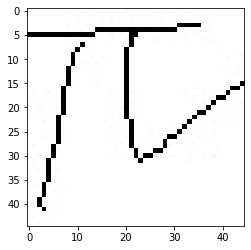

Predicted label = ['leq'], expected label = ['times']


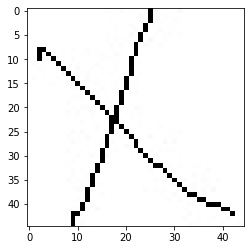

Predicted label = ['neq'], expected label = ['+']


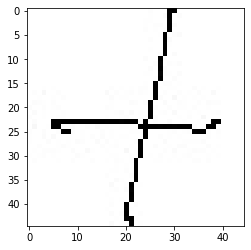

Predicted label = ['+'], expected label = ['div']


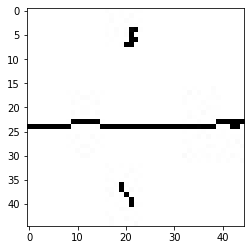

Predicted label = ['times'], expected label = ['pi']


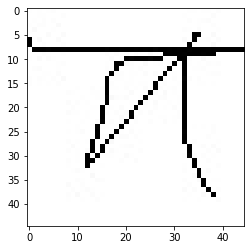

Predicted label = ['leq'], expected label = ['pi']


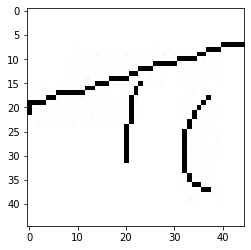

Predicted label = ['neq'], expected label = ['+']


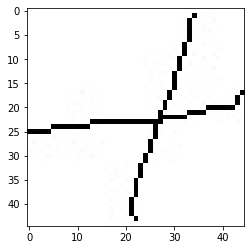

Predicted label = ['neq'], expected label = ['+']


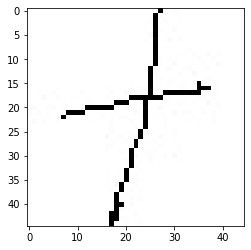

Predicted label = ['times'], expected label = ['pi']


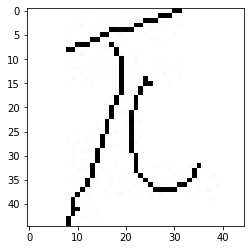

Predicted label = ['times'], expected label = ['+']


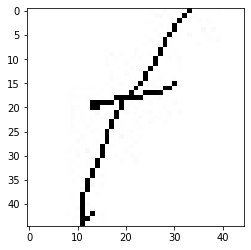

Predicted label = ['pm'], expected label = ['pi']


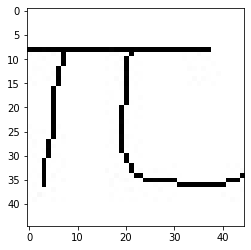

Predicted label = ['neq'], expected label = ['=']


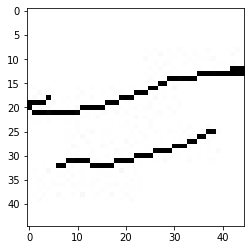

Predicted label = ['['], expected label = ['pm']


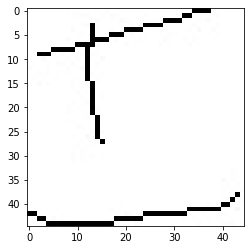

Predicted label = ['neq'], expected label = ['=']


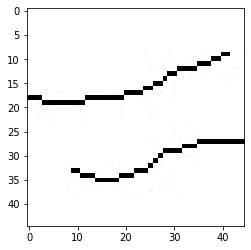

# of misclassificated images = 22


In [ ]:
count = 0
for j in range (len(ypred)):
  if ypred[j] != y_test[j]:
    print(f"Predicted label = {le.inverse_transform([ypred[j]])}, expected label = {le.inverse_transform([y_test[j]])}")
    count += 1
    plt.imshow(X_test[j], cmap='gray')
    plt.show()

print(f"# of misclassificated images = {count}")

##### **SVM - HOG, non gaussed**

In [ ]:
model = svm.SVC(kernel='rbf',C=10.0, random_state=42) # rbf Kernel
model.fit(X_train_HOG, y_train)
print("Train set Accuracy: {:.2f}".format(model.score(X_train_HOG,y_train)))

ypred = model.predict(X_test_HOG)

accuracy = metrics.accuracy_score(y_test, ypred)
print("Accuracy on test dataset:",accuracy)

Train set Accuracy: 1.00
Accuracy on test dataset: 0.991


              precision    recall  f1-score   support

           0       0.98      0.99      0.98        94
           1       0.98      0.97      0.98       111
           2       1.00      0.99      0.99        81
           3       0.99      1.00      1.00       105
           4       0.99      1.00      0.99        98
           5       1.00      1.00      1.00       105
           6       0.97      1.00      0.99       112
           7       1.00      1.00      1.00        98
           8       1.00      0.97      0.99       111
           9       1.00      0.99      0.99        85

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



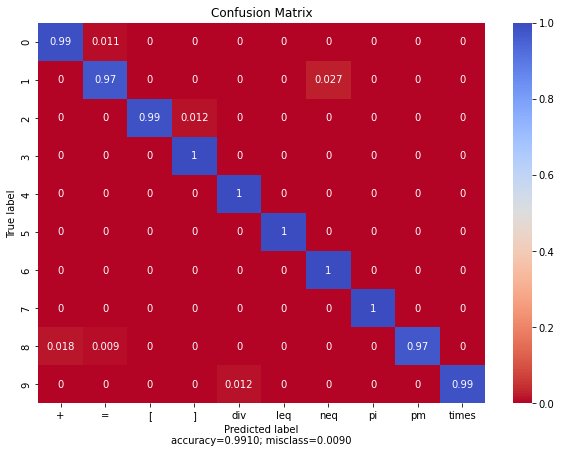

In [ ]:
cm1 = evaluator(y_test, ypred, labels = list(le.classes_))

Predicted label = ['+'], expected label = ['pm']


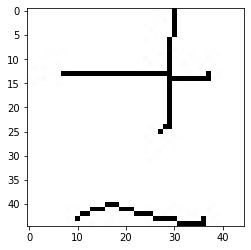

Predicted label = ['div'], expected label = ['times']


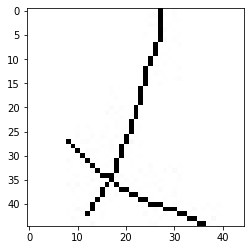

Predicted label = ['+'], expected label = ['pm']


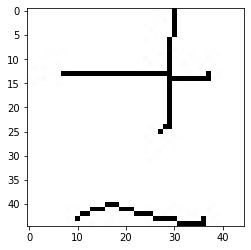

Predicted label = ['='], expected label = ['+']


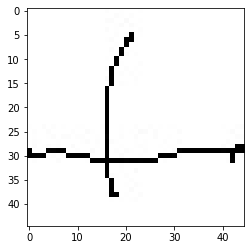

Predicted label = [']'], expected label = ['[']


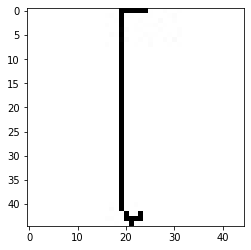

Predicted label = ['neq'], expected label = ['=']


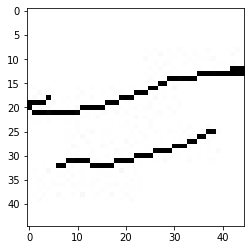

Predicted label = ['='], expected label = ['pm']


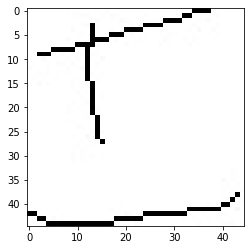

Predicted label = ['neq'], expected label = ['=']


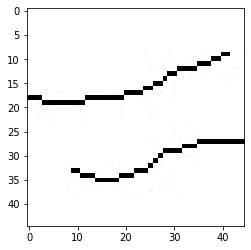

Predicted label = ['neq'], expected label = ['=']


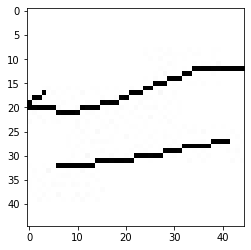

# of misclassificated images = 9


In [ ]:
count = 0
for j in range (len(ypred)):
  if ypred[j] != y_test[j]:
    print(f"Predicted label = {le.inverse_transform([ypred[j]])}, expected label = {le.inverse_transform([y_test[j]])}")
    count += 1
    plt.imshow(X_test[j],cmap='gray')
    plt.show()
    
print(f"# of misclassificated images = {count}")

##### **SVM - HOG, gaussed**

In [ ]:
model = svm.SVC(kernel='rbf',C=10.0, random_state=42) # rbf Kernel
model.fit(X_train_HOG_Gauss, y_train)
print("Train set Accuracy: {:.2f}".format(model.score(X_train_HOG_Gauss,y_train)))

ypred = model.predict(X_test_HOG_Gauss)

accuracy = metrics.accuracy_score(y_test, ypred)
print("Accuracy on test dataset:",accuracy)

Train set Accuracy: 1.00
Accuracy on test dataset: 0.997


              precision    recall  f1-score   support

           0       1.00      0.99      0.99        94
           1       0.99      1.00      1.00       111
           2       1.00      1.00      1.00        81
           3       1.00      1.00      1.00       105
           4       0.99      1.00      0.99        98
           5       1.00      1.00      1.00       105
           6       0.99      1.00      1.00       112
           7       1.00      1.00      1.00        98
           8       1.00      0.99      1.00       111
           9       1.00      0.99      0.99        85

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



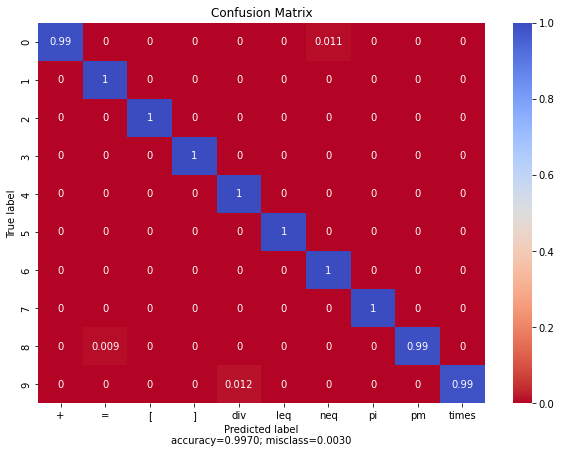

In [ ]:
cm1 = evaluator(y_test, ypred, labels = list(le.classes_))

Predicted label = ['div'], expected label = ['times']


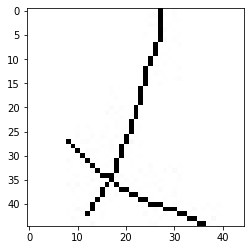

Predicted label = ['neq'], expected label = ['+']


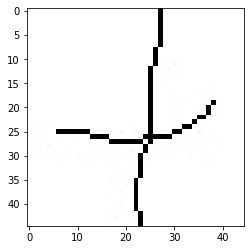

Predicted label = ['='], expected label = ['pm']


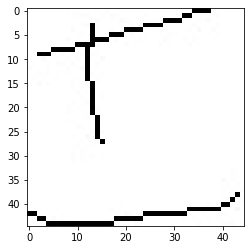

# of misclassificated images = 3


In [ ]:
count = 0
for j in range (len(ypred)):
  if ypred[j] != y_test[j]:
    print(f"Predicted label = {le.inverse_transform([ypred[j]])}, expected label = {le.inverse_transform([y_test[j]])}")
    count += 1
    plt.imshow(X_test[j],cmap='gray')
    plt.show()
    
print(f"# of misclassificated images = {count}")

### **Gabor, non gaussed**

In [ ]:
nsamples, nx, ny = X_train_Gabor.shape
d2_X_train_Gabor = X_train_Gabor.reshape((nsamples,nx*ny))
test_nsamples, nx, ny = X_test_Gabor.shape
d2_X_test_Gabor = X_test_Gabor.reshape((test_nsamples,nx*ny))

In [ ]:
model = svm.SVC(kernel='rbf',C=10.0, random_state=42) # rbf Kernel
model.fit(d2_X_train_Gabor, y_train)
print("Train set Accuracy: {:.2f}".format(model.score(d2_X_train_Gabor,y_train)))

ypred = model.predict(d2_X_test_Gabor)

accuracy = metrics.accuracy_score(y_test, ypred)
print("Accuracy on test dataset:",accuracy)

Train set Accuracy: 1.00
Accuracy on test dataset: 0.998


              precision    recall  f1-score   support

           0       1.00      0.99      0.99        94
           1       1.00      1.00      1.00       111
           2       1.00      1.00      1.00        81
           3       1.00      1.00      1.00       105
           4       1.00      1.00      1.00        98
           5       0.99      1.00      1.00       105
           6       1.00      1.00      1.00       112
           7       1.00      1.00      1.00        98
           8       1.00      1.00      1.00       111
           9       0.99      0.99      0.99        85

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



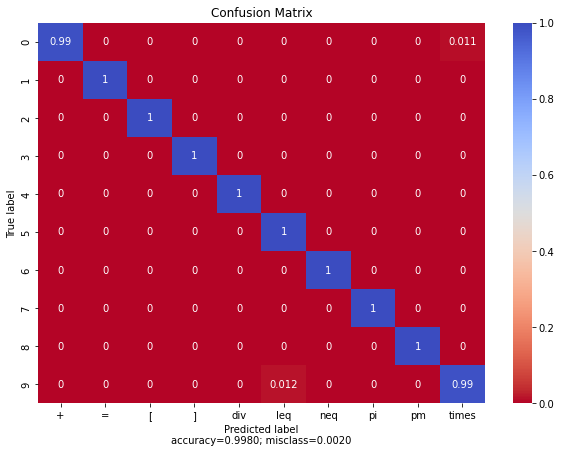

In [ ]:
cm1 = evaluator(y_test, ypred, labels = list(le.classes_))

Predicted label = ['leq'], expected label = ['times']


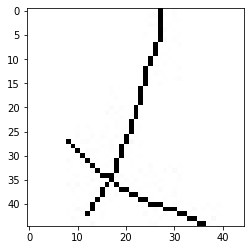

Predicted label = ['times'], expected label = ['+']


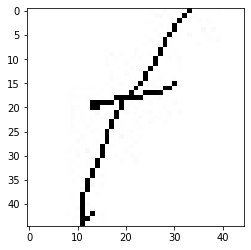

# of misclassificated images = 2


In [ ]:
count = 0
for j in range (len(ypred)):
  if ypred[j] != y_test[j]:
    print(f"Predicted label = {le.inverse_transform([ypred[j]])}, expected label = {le.inverse_transform([y_test[j]])}")
    count += 1
    plt.imshow(X_test[j], cmap='gray')
    plt.show()

print(f"# of misclassificated images = {count}")

### **Gabor, gaussed**

In [ ]:
model = svm.SVC(kernel='rbf',C=10.0, random_state=42) # rbf Kernel
nsamples, nx, ny = X_train_Gabor_Gauss.shape
d2_X_train_Gabor_Gauss = X_train_Gabor_Gauss.reshape((nsamples,nx*ny))
test_nsamples, nx, ny = X_test_Gabor_Gauss.shape
d2_X_test_Gabor_Gauss = X_test_Gabor_Gauss.reshape((test_nsamples,nx*ny))

In [ ]:
model.fit(d2_X_train_Gabor_Gauss, y_train)
print("Train set Accuracy: {:.2f}".format(model.score(d2_X_train_Gabor_Gauss,y_train)))

ypred = model.predict(d2_X_test_Gabor_Gauss)

accuracy = metrics.accuracy_score(y_test, ypred)
print("Accuracy on test dataset:",accuracy)

Train set Accuracy: 1.00
Accuracy on test dataset: 0.998


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      0.99      1.00       111
           2       1.00      1.00      1.00        81
           3       1.00      1.00      1.00       105
           4       1.00      1.00      1.00        98
           5       0.99      1.00      1.00       105
           6       1.00      1.00      1.00       112
           7       1.00      1.00      1.00        98
           8       0.99      1.00      1.00       111
           9       1.00      0.99      0.99        85

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



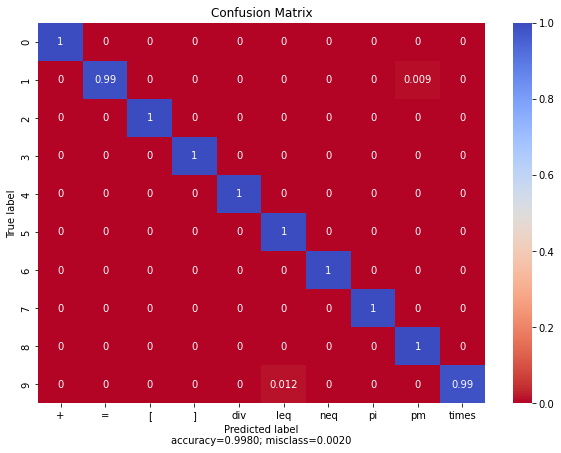

In [ ]:
cm1 = evaluator(y_test, ypred, labels = list(le.classes_))

Predicted label = ['leq'], expected label = ['times']


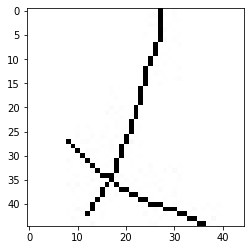

Predicted label = ['pm'], expected label = ['=']


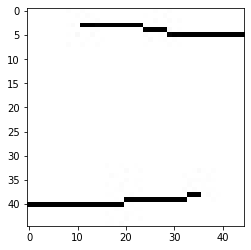

# of misclassificated images = 2


In [ ]:
count = 0
for j in range (len(ypred)):
  if ypred[j] != y_test[j]:
    print(f"Predicted label = {le.inverse_transform([ypred[j]])}, expected label = {le.inverse_transform([y_test[j]])}")
    count += 1
    plt.imshow(X_test[j], cmap='gray')
    plt.show()

print(f"# of misclassificated images = {count}")

### **LBPH, non gaussed**

In [ ]:
X_train_LBPH, X_val_LBPH, X_test_LBPH = hog_extractor(X_train_LBP), hog_extractor(X_val_LBP), hog_extractor(X_test_LBP)

In [ ]:
model = svm.SVC(kernel='rbf',C=10.0, random_state=42) # rbf Kernel
model.fit(X_train_LBPH, y_train)

print("Train set Accuracy: {:.2f}".format(model.score(X_train_LBPH, y_train)))

ypred = model.predict(X_test_LBPH)

accuracy = metrics.accuracy_score(y_test, ypred)
print("Accuracy on test dataset:",accuracy)


Train set Accuracy: 1.00
Accuracy on test dataset: 0.969


              precision    recall  f1-score   support

           0       0.94      0.89      0.92        94
           1       1.00      0.96      0.98       111
           2       0.98      1.00      0.99        81
           3       1.00      1.00      1.00       105
           4       0.98      0.97      0.97        98
           5       0.96      1.00      0.98       105
           6       0.89      1.00      0.94       112
           7       0.98      0.94      0.96        98
           8       1.00      0.96      0.98       111
           9       0.98      0.95      0.96        85

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



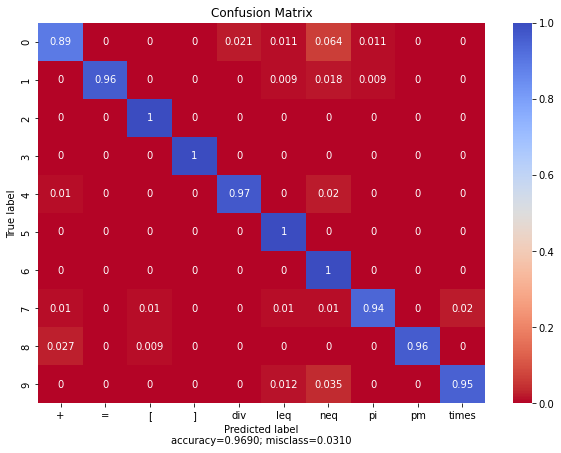

In [ ]:
cm1 = evaluator(y_test, ypred, labels = list(le.classes_))

Predicted label = ['+'], expected label = ['div']


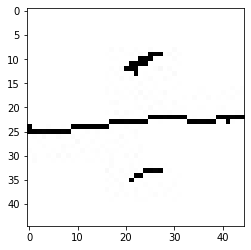

Predicted label = ['+'], expected label = ['pm']


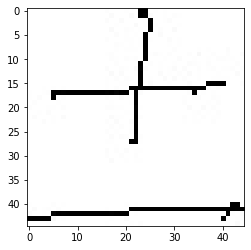

Predicted label = ['div'], expected label = ['+']


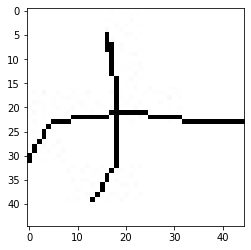

Predicted label = ['leq'], expected label = ['pi']


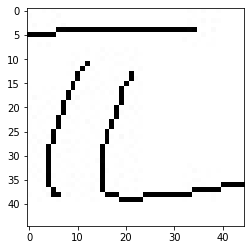

Predicted label = ['neq'], expected label = ['+']


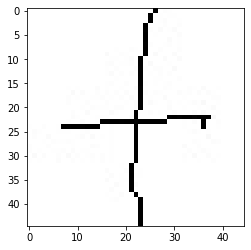

Predicted label = ['div'], expected label = ['+']


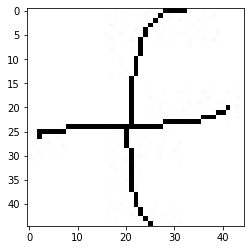

Predicted label = ['+'], expected label = ['pm']


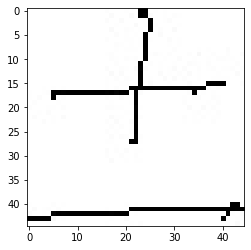

Predicted label = ['leq'], expected label = ['+']


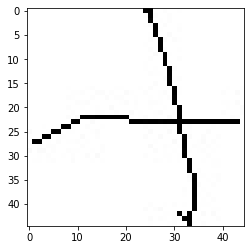

Predicted label = ['+'], expected label = ['pi']


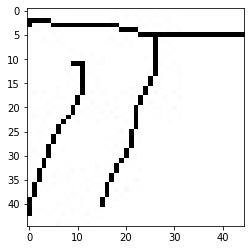

Predicted label = ['neq'], expected label = ['+']


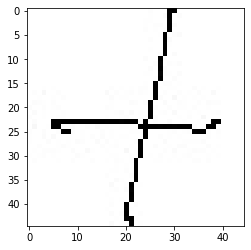

Predicted label = ['+'], expected label = ['pm']


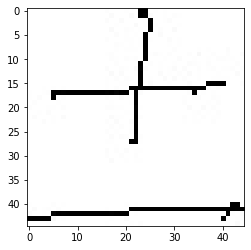

Predicted label = ['neq'], expected label = ['times']


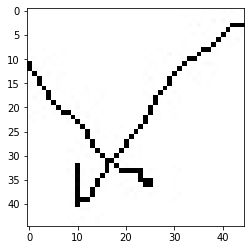

Predicted label = ['times'], expected label = ['pi']


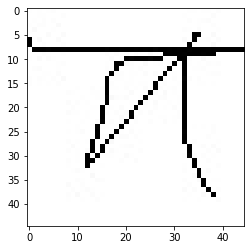

Predicted label = ['leq'], expected label = ['times']


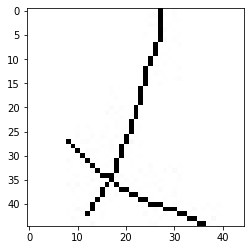

Predicted label = ['neq'], expected label = ['+']


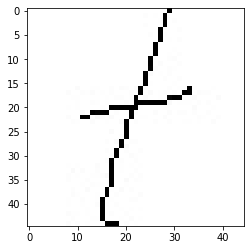

Predicted label = ['neq'], expected label = ['+']


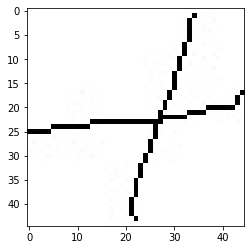

Predicted label = ['neq'], expected label = ['times']


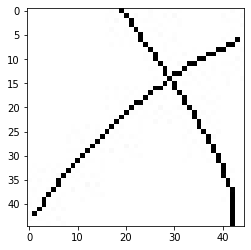

Predicted label = ['leq'], expected label = ['=']


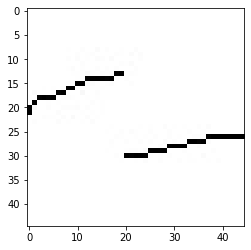

Predicted label = ['neq'], expected label = ['div']


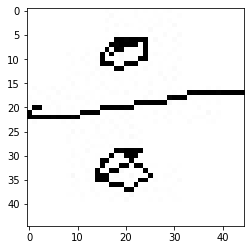

Predicted label = ['neq'], expected label = ['pi']


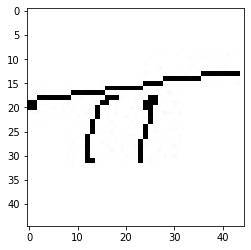

Predicted label = ['pi'], expected label = ['+']


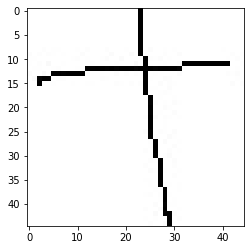

Predicted label = ['neq'], expected label = ['div']


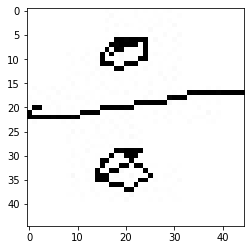

Predicted label = ['neq'], expected label = ['+']


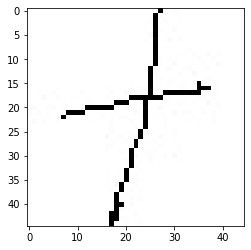

Predicted label = ['pi'], expected label = ['=']


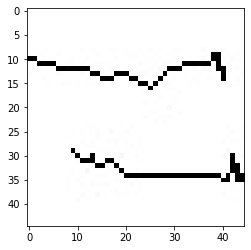

Predicted label = ['['], expected label = ['pi']


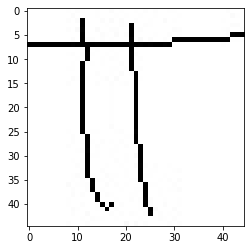

Predicted label = ['times'], expected label = ['pi']


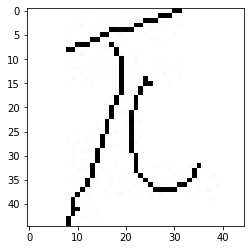

Predicted label = ['neq'], expected label = ['+']


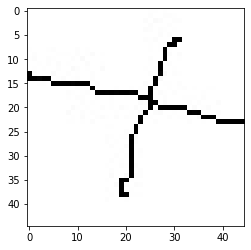

Predicted label = ['neq'], expected label = ['=']


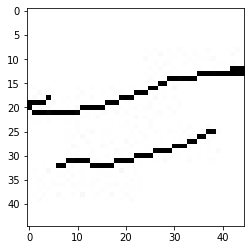

Predicted label = ['neq'], expected label = ['times']


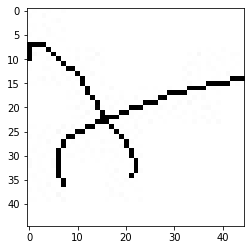

Predicted label = ['['], expected label = ['pm']


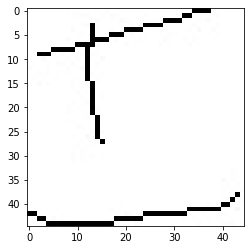

Predicted label = ['neq'], expected label = ['=']


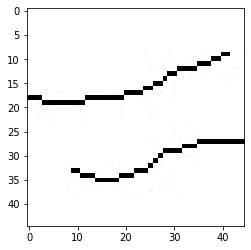

# of misclassificated images = 31


In [ ]:
count = 0
for j in range (len(ypred)):
  if ypred[j] != y_test[j]:
    print(f"Predicted label = {le.inverse_transform([ypred[j]])}, expected label = {le.inverse_transform([y_test[j]])}")
    count += 1
    plt.imshow(X_test[j], cmap='gray')
    plt.show()
    
print(f"# of misclassificated images = {count}")

### **LBPH, gaussed**

In [ ]:
X_train_LBPH_Gauss, X_val_LBPH_Gauss, X_test_LBPH_Gauss = hog_extractor(X_train_LBP_Gauss), hog_extractor(X_val_LBP_Gauss), hog_extractor(X_test_LBP_Gauss)

In [ ]:
model = svm.SVC(kernel='rbf',C=10.0, random_state=42) # rbf Kernel
model.fit(X_train_LBPH_Gauss, y_train)

print("Train set Accuracy: {:.2f}".format(model.score(X_train_LBPH_Gauss, y_train)))

ypred = model.predict(X_test_LBPH_Gauss)

accuracy = metrics.accuracy_score(y_test, ypred)
print("Accuracy on test dataset:",accuracy)


Train set Accuracy: 1.00
Accuracy on test dataset: 0.992


              precision    recall  f1-score   support

           0       0.98      0.97      0.97        94
           1       1.00      0.98      0.99       111
           2       0.99      1.00      0.99        81
           3       1.00      1.00      1.00       105
           4       0.99      1.00      0.99        98
           5       0.99      1.00      1.00       105
           6       0.97      1.00      0.99       112
           7       1.00      0.99      0.99        98
           8       1.00      0.99      1.00       111
           9       1.00      0.99      0.99        85

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



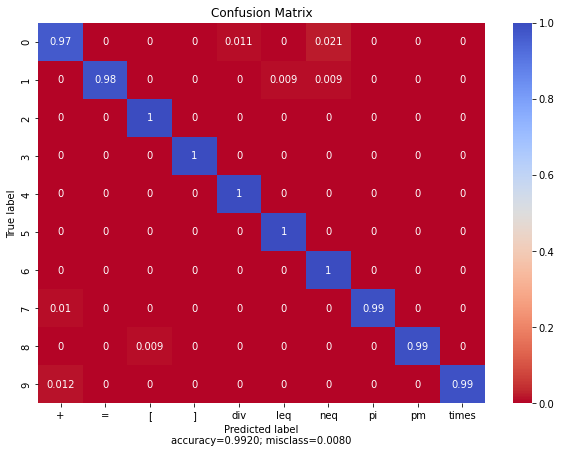

In [ ]:
cm1 = evaluator(y_test, ypred, labels = list(le.classes_))

Predicted label = ['+'], expected label = ['pi']


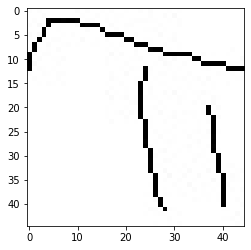

Predicted label = ['div'], expected label = ['+']


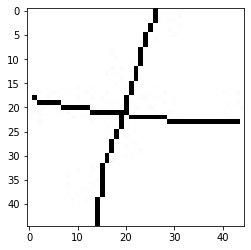

Predicted label = ['neq'], expected label = ['+']


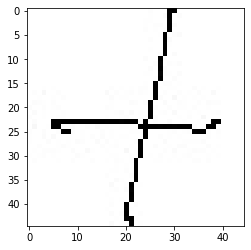

Predicted label = ['+'], expected label = ['times']


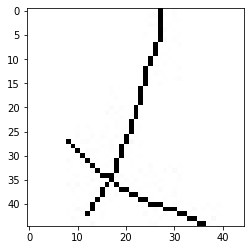

Predicted label = ['leq'], expected label = ['=']


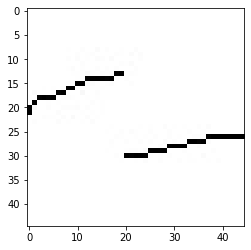

Predicted label = ['neq'], expected label = ['+']


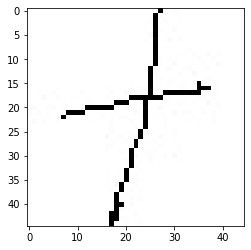

Predicted label = ['neq'], expected label = ['=']


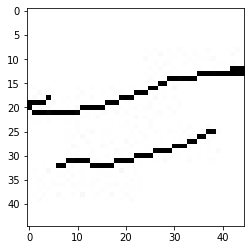

Predicted label = ['['], expected label = ['pm']


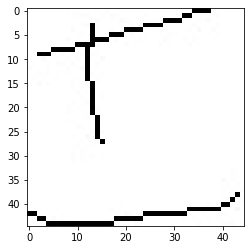

# of misclassificated images = 8


In [ ]:
count = 0
for j in range (len(ypred)):
  if ypred[j] != y_test[j]:
    print(f"Predicted label = {le.inverse_transform([ypred[j]])}, expected label = {le.inverse_transform([y_test[j]])}")
    count += 1
    plt.imshow(X_test[j], cmap='gray')
    plt.show()
    
print(f"# of misclassificated images = {count}")

### **Step 7) Hyperparameters tuning**

In [ ]:
model = svm.SVC(C = 10, random_state = 42) 
Cs = np.array(10 ** np.arange(-8,8, dtype = float))
train_errors = list()
test_errors = list()
for c in Cs:
    model.set_params(C = c)
    model.fit(X_train_HOG_Gauss, y_train)
    train_errors.append(model.score(X_train_HOG_Gauss, y_train))
    test_errors.append(model.score(X_test_HOG_Gauss, y_test))

i_c_optim = np.argmax(test_errors)
c_optim = Cs[i_c_optim]
print("Optimal regularization parameter : %s" % c_optim)

Optimal regularization parameter : 10.0


Text(0, 0.5, 'Performance')

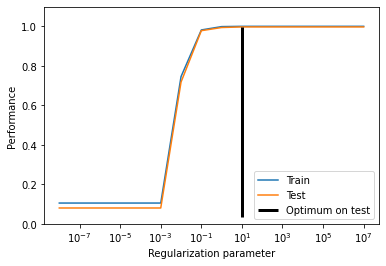

In [ ]:
plt.semilogx(Cs, train_errors, label="Train")
plt.semilogx(Cs, test_errors, label="Test")
plt.vlines(
    c_optim,
    plt.ylim()[0],
    np.max(test_errors),
    color="k",
    linewidth=3,
    label="Optimum on test",
)

plt.legend(loc="lower right")
plt.ylim([0.0, 1.1])
plt.xlabel("Regularization parameter")
plt.ylabel("Performance")

In [ ]:
optimal_model = svm.SVC(C = 10.0, random_state=42)
optimal_model.fit(d2_X_train_Gabor_Gauss, y_train)

print("Train set Accuracy: {:.2f}".format(optimal_model.score(d2_X_train_Gabor_Gauss, y_train)))

ypred = optimal_model.predict(d2_X_test_Gabor_Gauss)

accuracy = metrics.accuracy_score(y_test, ypred)
print("Accuracy on test dataset:",accuracy)


Train set Accuracy: 1.00
Accuracy on test dataset: 0.998


In [ ]:
model = svm.SVC(C = 10, random_state = 42)
Ks = ["linear", "poly", "rbf", "sigmoid", "precomputed"]
train_errors = list()
test_errors = list()
for k in Ks:
    model.set_params(kernel = k)
    if k == "precomputed":
      kernel_train = np.dot(d2_X_train_Gabor_Gauss, d2_X_train_Gabor_Gauss.T)  
      model.fit(kernel_train, y_train)
      train_errors.append(model.score(kernel_train, y_train))
      kernel_test = np.dot(d2_X_test_Gabor_Gauss, d2_X_train_Gabor_Gauss.T)
      test_errors.append(model.score(kernel_test, y_test))
    else:
      model.fit(d2_X_train_Gabor_Gauss, y_train)
      train_errors.append(model.score(d2_X_train_Gabor_Gauss, y_train))
      test_errors.append(model.score(d2_X_test_Gabor_Gauss, y_test))



i_k_optim = np.argmax(test_errors)
k_optim = Ks[i_k_optim]
winner = np.argwhere(test_errors == np.amax(test_errors))
Ks = np.array(Ks)
print(f"Optimal kernel parameters are: {str(Ks[winner.flatten().tolist()])}") 

Optimal kernel parameters are: ['rbf']


Text(0, 0.5, 'Performance')

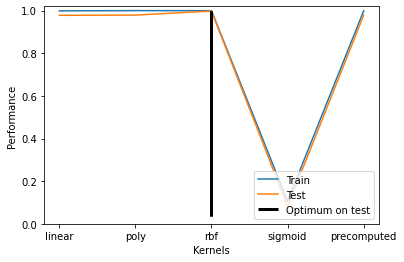

In [ ]:
plt.plot(Ks, train_errors, label="Train")
plt.plot(Ks, test_errors, label="Test")
plt.vlines(
    (k_optim, "rbf"),
    plt.ylim()[0],
    np.max(test_errors),
    color="k",
    linewidth=3,
    label="Optimum on test",
)

plt.legend(loc="lower right")
plt.ylim([0.0, 1.02])
plt.xlabel("Kernels")
plt.ylabel("Performance")

### **Step 8) Performance evaluation**
 

In [ ]:
from sklearn.model_selection import cross_val_score

# this cell might take few seconds to run

def kernelizer(data):
    return np.dot(data, data.T)

raw = cross_val_score(model, kernelizer(d2_X_train), y_train, scoring = 'f1_weighted', cv = 10)
raw_gauss = cross_val_score(model, kernelizer(d2_X_train_Gauss), y_train, scoring = 'f1_weighted', cv = 10)

lbp = cross_val_score(model, kernelizer(d2_X_train_LBP), y_train, scoring = 'f1_weighted', cv = 10)
lbp_gauss = cross_val_score(model, kernelizer(d2_X_train_LBP_Gauss), y_train, scoring = 'f1_weighted', cv = 10)

hog = cross_val_score(model, kernelizer(X_train_HOG), y_train, scoring = 'f1_weighted', cv = 10)
hog_gauss = cross_val_score(model, kernelizer(X_train_HOG_Gauss), y_train, scoring = 'f1_weighted', cv = 10)

lbph = cross_val_score(model, kernelizer(X_train_LBPH), y_train, scoring = 'f1_weighted', cv = 10)
lbph_gauss = cross_val_score(model, kernelizer(X_train_LBPH_Gauss), y_train, scoring = 'f1_weighted', cv = 10)

gabor = cross_val_score(model, kernelizer(d2_X_train_Gabor), y_train, scoring = 'f1_weighted', cv = 10)
gabor_gauss = cross_val_score(model, kernelizer(d2_X_train_Gabor_Gauss), y_train, scoring = 'f1_weighted', cv = 10)

In [ ]:
scores = [raw, lbp, hog, lbph, gabor]
labels = ["Raw Pixels", "LBP processed", "HOG processed", "LBPH processed", "Gabor processed"]
RED_DARK = "#850e00"

def compare_scores(labels, scores, title= "Non Gaussed data", cv = 10):
    means = [p.mean() for p in scores]
    plt.figure(figsize=(12,6))
    for i, mean in enumerate(means):
        plt.plot([i]*cv, scores[i],'.')
        plt.scatter(i, mean, s=250, color=RED_DARK, zorder=3)
        plt.plot([i, i + 0.25], [mean, mean], ls="dashdot", color="black", zorder=3)
        plt.text(
        i + 0.25,
        mean,
        r"$acc_{\rm{mean}} = $" + str(round(mean, 3)),
        fontsize=13,
        va="center",
        bbox = dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round",
            pad=0.15
        ),
        zorder=10 # to make sure the line is on top
    )
        
    sns.boxplot(data = pd.DataFrame(np.array(scores).T, columns = labels), palette = 'coolwarm_r').set(title = title, ylabel = "weighted F1")

    plt.show()

In [ ]:
sns.set_style("dark")
compare_scores(labels, scores)

In [ ]:
scores = [raw_gauss, lbp_gauss, hog_gauss, lbph_gauss, gabor_gauss]
compare_scores(labels, scores, "Gaussed data")

### **Artificial Neural Network**

I will try to experiment the training sets I extracted with different parametrizations, from hidden layers/nodes combinations to different learning rates methods. 

The function here will serve the purpose of initializing the neural network with parameters being the size of the pics, the number of hidden layers, etc.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def neural(px = 45, py = 45,
           hidden = 1,
           nodes = [128],
           classes = 10,
           activation = "relu",
           lr = 0.001,
           loss = 'sparse_categorical_crossentropy',
           optimizer = 'SGD',
           regularization = False,
           momentum = 0.0):
  NN = tf.keras.models.Sequential()
  NN.add(tf.keras.layers.Flatten(input_shape=[px,py]))
  for i in range(hidden):
    if regularization:
      NN.add(tf.keras.layers.Dense(nodes[i], activation=activation, kernel_regularizer=regularizers.L1L2(l1=5e-5, l2=5e-4)))
    else:
      NN.add(tf.keras.layers.Dense(nodes[i], activation=activation))
    

  NN.add(tf.keras.layers.Dense(classes, activation='softmax'))
  
  
  if momentum != 0.0:
    sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum = momentum, nesterov = True)  
  else:
    sgd = tf.keras.optimizers.SGD(learning_rate=lr)

  
  NN.compile(loss= loss, optimizer= sgd, metrics=['accuracy'])


  return NN

In [ ]:
def NN_evaluator(model, hist, X_test, y_test):
  ypred = neural_net.predict(X_test)

  predictions = []
  for x in ypred:
    i = np.argmax(x)
    predictions.append(i)

  predictions = np.array(predictions)
  accuracy = (np.sum((y_test - predictions) != 0))/ X_test.shape[0]
  print(f"number of misclassified datapoints = {np.sum((y_test - predictions) != 0)}; accuracy = {1 - accuracy}")

  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def NN_loss_evaluator(hist):
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

I will start evaluating a very simple 1-layer MLP with 128 nodes in its sole hidden layer. In a 1-hidden layer neural network, the decision boundary can be a relatively simple surface, such as a linear boundary or a piecewise linear boundary. This is because the hidden layer can only learn a single set of features from the input data and transform them into a higher-level representation. Though, by increasing the number of nodes, this linear decison boundary can be made more fragmented and thus more complex.

I will also create a callback for EarlyStopping, a function that allows me to stop the training before the end of the epochs if the `val_accuracy` doesn't improve for `patience` (I set =30) consecutive times.

In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=20)
callbacks_list = [es]

Through the function `summary()`, we can get an overview of the network, layer by layer.

In [ ]:
neural_net = neural(hidden = 1, nodes = [128])
neural_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2025)              0         
                                                                 
 dense (Dense)               (None, 128)               259328    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 260,618
Trainable params: 260,618
Non-trainable params: 0
_________________________________________________________________


### **Step 1) Raw pixel data**

##### **First experiment: constant learning rate - `batch_size = 16`, standard learning rate**

I will first evaluate for non Gaussed and then for Gaussed data. The mentioned approach will be used throughout the whole experiment for each feature. 

###### **Raw, non gaussed**

In [ ]:
neural_net = neural(hidden = 1, nodes = [128])
hist = neural_net.fit(X_train, y_train, epochs = 500, batch_size = 16, validation_data=(X_val, y_val), callbacks = callbacks_list)

Epoch 1/500
219/219 [==============================] - 2s 7ms/step - loss: 2.3119 - accuracy: 0.1251 - val_loss: 2.2596 - val_accuracy: 0.1340
Epoch 2/500
219/219 [==============================] - 1s 6ms/step - loss: 2.2144 - accuracy: 0.1991 - val_loss: 2.1815 - val_accuracy: 0.2320
Epoch 3/500
219/219 [==============================] - 2s 10ms/step - loss: 2.1340 - accuracy: 0.2494 - val_loss: 2.1661 - val_accuracy: 0.1640
Epoch 4/500
219/219 [==============================] - 3s 12ms/step - loss: 2.0650 - accuracy: 0.3283 - val_loss: 2.0365 - val_accuracy: 0.3220
Epoch 5/500
219/219 [==============================] - 2s 9ms/step - loss: 1.9890 - accuracy: 0.3846 - val_loss: 1.9757 - val_accuracy: 0.3380
Epoch 6/500
219/219 [==============================] - 2s 8ms/step - loss: 1.9182 - accuracy: 0.4440 - val_loss: 1.8935 - val_accuracy: 0.4740
Epoch 7/500
219/219 [==============================] - 2s 11ms/step - loss: 1.8476 - accuracy: 0.4823 - val_loss: 1.8430 - val_accuracy: 0.4

32/32 [==============================] - 0s 2ms/step
number of misclassified datapoints = 67; accuracy = 0.933


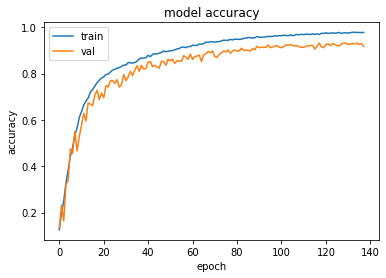

In [ ]:
NN_evaluator(neural_net, hist, X_test, y_test)

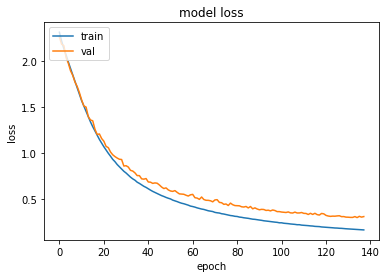

In [ ]:
NN_loss_evaluator(hist)

###### **Raw, gaussed**

In [ ]:
neural_net = neural(hidden = 1, nodes = [128])
hist = neural_net.fit(X_train_Gauss, y_train, epochs = 500, batch_size = 16, validation_data=(X_val_Gauss, y_val), callbacks = callbacks_list)

Epoch 1/500
219/219 [==============================] - 2s 6ms/step - loss: 2.3020 - accuracy: 0.1291 - val_loss: 2.2623 - val_accuracy: 0.1680
Epoch 2/500
219/219 [==============================] - 2s 9ms/step - loss: 2.2286 - accuracy: 0.1997 - val_loss: 2.2196 - val_accuracy: 0.1740
Epoch 3/500
219/219 [==============================] - 2s 9ms/step - loss: 2.1659 - accuracy: 0.2511 - val_loss: 2.1779 - val_accuracy: 0.1620
Epoch 4/500
219/219 [==============================] - 2s 10ms/step - loss: 2.1109 - accuracy: 0.3226 - val_loss: 2.0771 - val_accuracy: 0.2900
Epoch 5/500
219/219 [==============================] - 2s 9ms/step - loss: 2.0490 - accuracy: 0.3694 - val_loss: 2.0244 - val_accuracy: 0.4020
Epoch 6/500
219/219 [==============================] - 3s 14ms/step - loss: 1.9913 - accuracy: 0.4294 - val_loss: 1.9635 - val_accuracy: 0.5180
Epoch 7/500
219/219 [==============================] - 3s 14ms/step - loss: 1.9320 - accuracy: 0.4969 - val_loss: 1.9203 - val_accuracy: 0.4

32/32 [==============================] - 0s 2ms/step
number of misclassified datapoints = 88; accuracy = 0.912


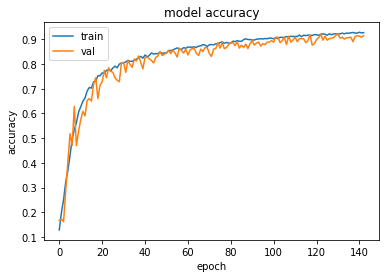

In [ ]:
NN_evaluator(neural_net, hist, X_test_Gauss, y_test)

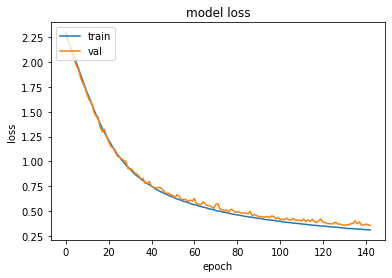

In [ ]:
NN_loss_evaluator(hist)

##### **Second experiment: constant learning rate - `batch_size = 32`, `learning_rate = 0.008`**

The runtime of the two models is huge! By tweaking the `batch size` (16 --> 32), I should be attaining a much faster runtime, without significant drops in performance. To offset this change, I will also increase the learning rate, as the updates may be smaller in magnitude now.

###### **Raw, non gaussed**

In [ ]:
neural_net = neural(hidden = 1, nodes = [128], lr = 0.008)
hist = neural_net.fit(X_train, y_train,
                      epochs = 500,
                      batch_size = 32,
                      validation_data=(X_val, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 1s 7ms/step - loss: 2.3190 - accuracy: 0.1529 - val_loss: 2.2791 - val_accuracy: 0.1280
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 2.1354 - accuracy: 0.2397 - val_loss: 2.2892 - val_accuracy: 0.1260
Epoch 3/500
110/110 [==============================] - 1s 9ms/step - loss: 1.9942 - accuracy: 0.3146 - val_loss: 2.4719 - val_accuracy: 0.1560
Epoch 4/500
110/110 [==============================] - 1s 8ms/step - loss: 1.8479 - accuracy: 0.4000 - val_loss: 1.9541 - val_accuracy: 0.2040
Epoch 5/500
110/110 [==============================] - 1s 8ms/step - loss: 1.6690 - accuracy: 0.4586 - val_loss: 1.5849 - val_accuracy: 0.5060
Epoch 6/500
110/110 [==============================] - 1s 8ms/step - loss: 1.5092 - accuracy: 0.5286 - val_loss: 1.5407 - val_accuracy: 0.4640
Epoch 7/500
110/110 [==============================] - 1s 8ms/step - loss: 1.3903 - accuracy: 0.5634 - val_loss: 1.6185 - val_accuracy: 0.4060

32/32 [==============================] - 0s 2ms/step
number of misclassified datapoints = 57; accuracy = 0.943


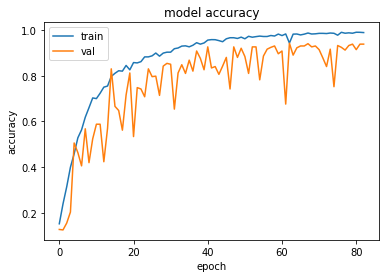

In [ ]:
NN_evaluator(neural_net, hist, X_test, y_test)

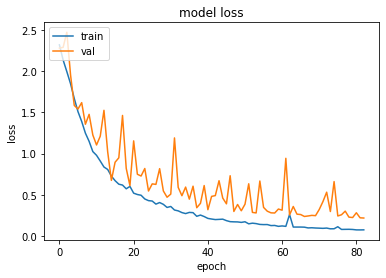

In [ ]:
NN_loss_evaluator(hist)

###### **Raw, gaussed**

In [ ]:
neural_net = neural(hidden = 1, nodes = [128], lr = 0.008)
hist = neural_net.fit(X_train_Gauss, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_Gauss, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 2.3418 - accuracy: 0.1420 - val_loss: 2.3629 - val_accuracy: 0.1360
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 2.1650 - accuracy: 0.2037 - val_loss: 2.6305 - val_accuracy: 0.1240
Epoch 3/500
110/110 [==============================] - 1s 8ms/step - loss: 2.0303 - accuracy: 0.2831 - val_loss: 2.4529 - val_accuracy: 0.0920
Epoch 4/500
110/110 [==============================] - 1s 13ms/step - loss: 1.8890 - accuracy: 0.3677 - val_loss: 1.9742 - val_accuracy: 0.2220
Epoch 5/500
110/110 [==============================] - 1s 13ms/step - loss: 1.7580 - accuracy: 0.4111 - val_loss: 1.7012 - val_accuracy: 0.4560
Epoch 6/500
110/110 [==============================] - 1s 12ms/step - loss: 1.6293 - accuracy: 0.4717 - val_loss: 1.7007 - val_accuracy: 0.4280
Epoch 7/500
110/110 [==============================] - 1s 11ms/step - loss: 1.5093 - accuracy: 0.5297 - val_loss: 1.6975 - val_accuracy: 0.

32/32 [==============================] - 0s 4ms/step
number of misclassified datapoints = 143; accuracy = 0.857


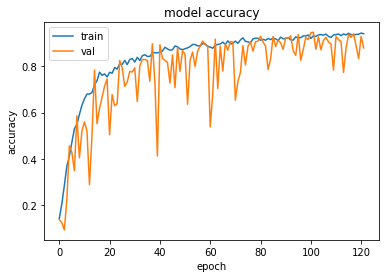

In [ ]:
NN_evaluator(neural_net, hist, X_test_Gauss, y_test)

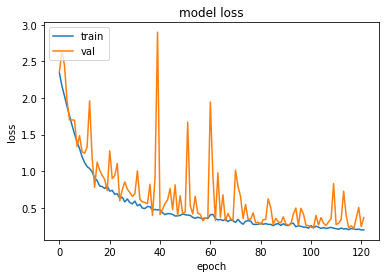

In [ ]:
NN_loss_evaluator(hist)

Since there are large fluctuations, we can work on the smoothing implementing a `regularization` in our SGD function.

##### **Raw, non gaussed, regularized, OVERFITTING!**

In [ ]:
neural_net = neural(hidden = 1, nodes = [128], lr = 0.008, regularization= True)
hist = neural_net.fit(X_train, y_train,
                      epochs = 500,
                      batch_size = 32,
                      validation_data=(X_val, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 3s 13ms/step - loss: 2.7652 - accuracy: 0.1557 - val_loss: 2.8255 - val_accuracy: 0.1400
Epoch 2/500
110/110 [==============================] - 1s 6ms/step - loss: 2.5581 - accuracy: 0.2317 - val_loss: 3.2959 - val_accuracy: 0.1380
Epoch 3/500
110/110 [==============================] - 1s 7ms/step - loss: 2.3904 - accuracy: 0.3331 - val_loss: 2.6300 - val_accuracy: 0.1520
Epoch 4/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2024 - accuracy: 0.4100 - val_loss: 2.3282 - val_accuracy: 0.2420
Epoch 5/500
110/110 [==============================] - 1s 10ms/step - loss: 2.0352 - accuracy: 0.5006 - val_loss: 2.0824 - val_accuracy: 0.4580
Epoch 6/500
110/110 [==============================] - 1s 11ms/step - loss: 1.8899 - accuracy: 0.5543 - val_loss: 1.9296 - val_accuracy: 0.5020
Epoch 7/500
110/110 [==============================] - 1s 11ms/step - loss: 1.7719 - accuracy: 0.5891 - val_loss: 1.9969 - val_accuracy: 0.

32/32 [==============================] - 0s 5ms/step
number of misclassified datapoints = 65; accuracy = 0.935


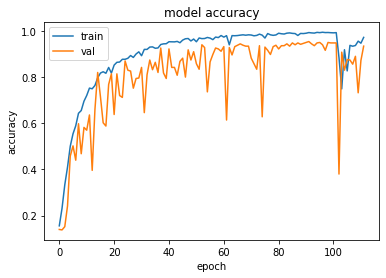

In [ ]:
NN_evaluator(neural_net, hist, X_test, y_test)

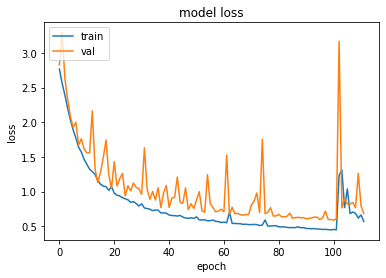

In [ ]:
NN_loss_evaluator(hist)

Some overfitting occoured in the non-gaussed data. Addressing such issue through EarlyStopping on `val_loss` instead of `val_accuracy`.

###### **Raw, non gaussed, addressing overfitting**

In [ ]:
es2 = EarlyStopping(monitor='val_loss', patience=10)
neural_net = neural(hidden = 1, nodes = [128], lr = 0.008, regularization= True)
hist = neural_net.fit(X_train, y_train,
                      epochs = 500,
                      batch_size = 32,
                      validation_data=(X_val, y_val), callbacks = [es2])

Epoch 1/500
110/110 [==============================] - 3s 15ms/step - loss: 2.8000 - accuracy: 0.1486 - val_loss: 2.8207 - val_accuracy: 0.1000
Epoch 2/500
110/110 [==============================] - 1s 10ms/step - loss: 2.5945 - accuracy: 0.2177 - val_loss: 2.6910 - val_accuracy: 0.1540
Epoch 3/500
110/110 [==============================] - 1s 11ms/step - loss: 2.4205 - accuracy: 0.3120 - val_loss: 2.9428 - val_accuracy: 0.1720
Epoch 4/500
110/110 [==============================] - 1s 11ms/step - loss: 2.2586 - accuracy: 0.3986 - val_loss: 2.2172 - val_accuracy: 0.3540
Epoch 5/500
110/110 [==============================] - 1s 13ms/step - loss: 2.0909 - accuracy: 0.4554 - val_loss: 1.9794 - val_accuracy: 0.5700
Epoch 6/500
110/110 [==============================] - 1s 8ms/step - loss: 1.9311 - accuracy: 0.5311 - val_loss: 2.0073 - val_accuracy: 0.4920
Epoch 7/500
110/110 [==============================] - 1s 10ms/step - loss: 1.8091 - accuracy: 0.5823 - val_loss: 1.9703 - val_accuracy: 

32/32 [==============================] - 0s 4ms/step
number of misclassified datapoints = 52; accuracy = 0.948


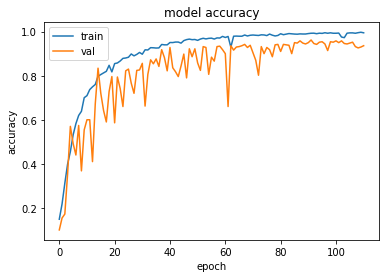

In [ ]:
NN_evaluator(neural_net, hist, X_test, y_test)

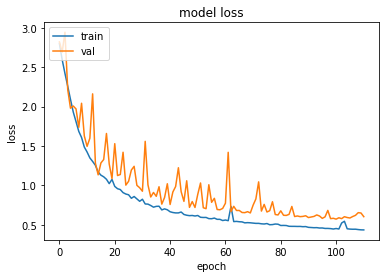

In [ ]:
NN_loss_evaluator(hist)

##### **Raw, gaussed, regularized**

In [ ]:
neural_net = neural(hidden = 1, nodes = [128], lr = 0.008, regularization= True)
hist = neural_net.fit(X_train_Gauss, y_train,
                      epochs = 500,
                      batch_size = 32,
                      validation_data=(X_val, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 13ms/step - loss: 2.8087 - accuracy: 0.1357 - val_loss: 2.7617 - val_accuracy: 0.1120
Epoch 2/500
110/110 [==============================] - 1s 8ms/step - loss: 2.6581 - accuracy: 0.1800 - val_loss: 2.7518 - val_accuracy: 0.1460
Epoch 3/500
110/110 [==============================] - 1s 6ms/step - loss: 2.5329 - accuracy: 0.2734 - val_loss: 2.7949 - val_accuracy: 0.0920
Epoch 4/500
110/110 [==============================] - 1s 6ms/step - loss: 2.4343 - accuracy: 0.3397 - val_loss: 2.4388 - val_accuracy: 0.2420
Epoch 5/500
110/110 [==============================] - 1s 7ms/step - loss: 2.2973 - accuracy: 0.3951 - val_loss: 2.1916 - val_accuracy: 0.4560
Epoch 6/500
110/110 [==============================] - 1s 6ms/step - loss: 2.1755 - accuracy: 0.4714 - val_loss: 2.0888 - val_accuracy: 0.4660
Epoch 7/500
110/110 [==============================] - 1s 7ms/step - loss: 2.0693 - accuracy: 0.5000 - val_loss: 2.0947 - val_accuracy: 0.402

32/32 [==============================] - 0s 6ms/step
number of misclassified datapoints = 75; accuracy = 0.925


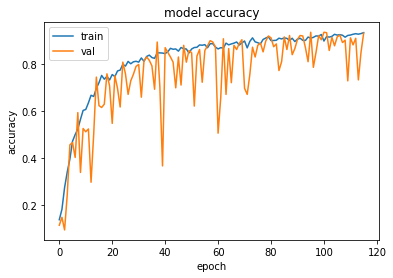

In [ ]:
NN_evaluator(neural_net, hist, X_test_Gauss, y_test)

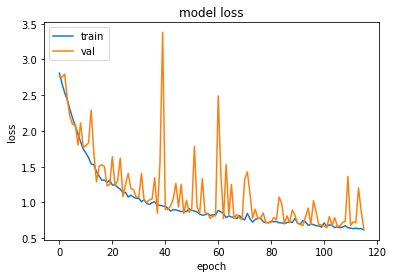

In [ ]:
NN_loss_evaluator(hist)

Takeaways from the preceding experiments:


*   Increasing the batch size worked on making the model training faster, keeping performance unchanged if not improved. One drawback of this method is given by the larger fluctuation in the validation set. A possible explanation can be  the fact that the validation set is rather small (500 data points) and thus not heterogeneous enough;
*   The increase in learning rate made the fitting quicker;
*   Regularization reduced sensibly fluctuations, although increasing the runtime due to increase in complexity of computations. Given the marginal increase in performance that can be addressed in other ways (see below), I will disregard regularization from now on;
*   The model with one single hidden layer performs surprisingly well, but lacks probably some more complexity that can be addressed by adding 1-2 hidden layers.



### **Step 2) LBP processed data**


##### **Constant learning rate, non gaussed**

In [ ]:
neural_net = neural(hidden = 1, nodes = [128])
hist = neural_net.fit(X_train_LBP, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_LBP, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 7ms/step - loss: 3.4349 - accuracy: 0.1606 - val_loss: 2.3520 - val_accuracy: 0.1040
Epoch 2/500
110/110 [==============================] - 1s 5ms/step - loss: 2.1662 - accuracy: 0.2100 - val_loss: 2.2650 - val_accuracy: 0.1340
Epoch 3/500
110/110 [==============================] - 1s 5ms/step - loss: 2.0259 - accuracy: 0.2786 - val_loss: 2.4490 - val_accuracy: 0.2000
Epoch 4/500
110/110 [==============================] - 1s 6ms/step - loss: 1.8967 - accuracy: 0.3220 - val_loss: 2.1384 - val_accuracy: 0.2400
Epoch 5/500
110/110 [==============================] - 1s 5ms/step - loss: 1.7631 - accuracy: 0.3834 - val_loss: 1.9126 - val_accuracy: 0.2820
Epoch 6/500
110/110 [==============================] - 1s 6ms/step - loss: 1.6013 - accuracy: 0.4383 - val_loss: 1.5774 - val_accuracy: 0.4340
Epoch 7/500
110/110 [==============================] - 1s 5ms/step - loss: 1.4909 - accuracy: 0.4803 - val_loss: 1.5885 - val_accuracy: 0.4520

32/32 [==============================] - 0s 4ms/step
number of misclassified datapoints = 69; accuracy = 0.931


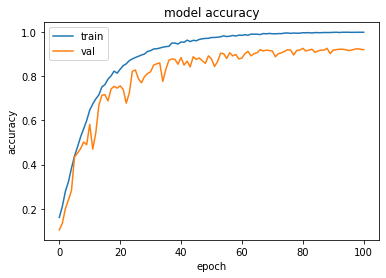

In [ ]:
NN_evaluator(neural_net, hist, X_test_LBP, y_test)

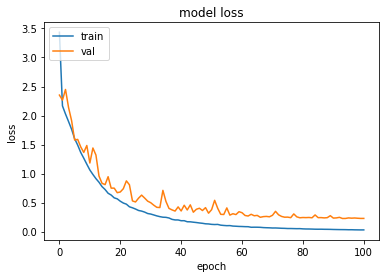

In [ ]:
NN_loss_evaluator(hist)

##### **Constant learning rate, gaussed**

In [ ]:
neural_net = neural(hidden = 1, nodes = [128])
hist = neural_net.fit(X_train_LBP_Gauss, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_LBP_Gauss, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 8ms/step - loss: 2.7634 - accuracy: 0.3623 - val_loss: 1.9687 - val_accuracy: 0.2900
Epoch 2/500
110/110 [==============================] - 1s 5ms/step - loss: 1.1221 - accuracy: 0.6134 - val_loss: 1.2302 - val_accuracy: 0.5720
Epoch 3/500
110/110 [==============================] - 1s 5ms/step - loss: 0.8489 - accuracy: 0.7137 - val_loss: 1.1310 - val_accuracy: 0.5860
Epoch 4/500
110/110 [==============================] - 1s 5ms/step - loss: 0.6640 - accuracy: 0.7709 - val_loss: 0.8425 - val_accuracy: 0.6980
Epoch 5/500
110/110 [==============================] - 1s 6ms/step - loss: 0.5842 - accuracy: 0.8063 - val_loss: 0.6754 - val_accuracy: 0.7460
Epoch 6/500
110/110 [==============================] - 1s 5ms/step - loss: 0.5182 - accuracy: 0.8271 - val_loss: 0.4955 - val_accuracy: 0.8420
Epoch 7/500
110/110 [==============================] - 1s 5ms/step - loss: 0.4751 - accuracy: 0.8423 - val_loss: 0.5445 - val_accuracy: 0.8060

32/32 [==============================] - 0s 3ms/step
number of misclassified datapoints = 57; accuracy = 0.943


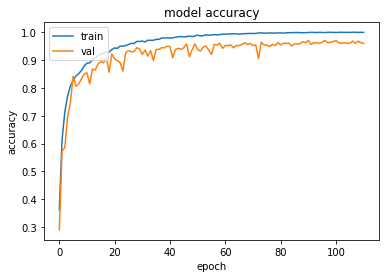

In [ ]:
NN_evaluator(neural_net, hist, X_test_LBP_Gauss, y_test)

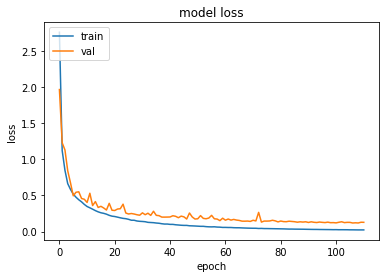

In [ ]:
NN_loss_evaluator(hist)

### **Step 2) HOG processed data**

##### **Constant learning rate, `batch_size = 32`, non gaussed**

In [ ]:
ax,ay = X_train_HOG.shape 
td_HOG_train = X_train_HOG.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))
td_HOG_train_Gauss = X_train_HOG_Gauss.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))

ax,ay = X_val_HOG.shape
td_HOG_val = X_val_HOG.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))
td_HOG_val_Gauss = X_val_HOG_Gauss.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))

ax,ay = X_test_HOG.shape
td_HOG_test = X_test_HOG.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))
td_HOG_test_Gauss = X_test_HOG_Gauss.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))

ax,ay,az = td_HOG_train.shape

neural_net = neural(px = az, py = az, hidden = 1, nodes = [128], lr = 0.008)
hist = neural_net.fit(td_HOG_train, y_train, epochs = 500, batch_size = 32, validation_data=(td_HOG_val, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 1s 5ms/step - loss: 2.2394 - accuracy: 0.2226 - val_loss: 2.1671 - val_accuracy: 0.3860
Epoch 2/500
110/110 [==============================] - 0s 4ms/step - loss: 2.1047 - accuracy: 0.5211 - val_loss: 2.0310 - val_accuracy: 0.6420
Epoch 3/500
110/110 [==============================] - 0s 3ms/step - loss: 1.9632 - accuracy: 0.7063 - val_loss: 1.8830 - val_accuracy: 0.7520
Epoch 4/500
110/110 [==============================] - 0s 4ms/step - loss: 1.8109 - accuracy: 0.7749 - val_loss: 1.7250 - val_accuracy: 0.8020
Epoch 5/500
110/110 [==============================] - 0s 4ms/step - loss: 1.6530 - accuracy: 0.8171 - val_loss: 1.5652 - val_accuracy: 0.8320
Epoch 6/500
110/110 [==============================] - 0s 4ms/step - loss: 1.4956 - accuracy: 0.8369 - val_loss: 1.4093 - val_accuracy: 0.8440
Epoch 7/500
110/110 [==============================] - 0s 4ms/step - loss: 1.3454 - accuracy: 0.8571 - val_loss: 1.2649 - val_accuracy: 0.8440

32/32 [==============================] - 0s 2ms/step
number of misclassified datapoints = 39; accuracy = 0.961


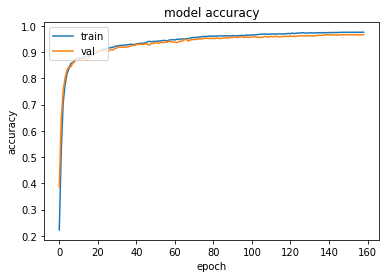

In [ ]:
NN_evaluator(neural_net, hist, td_HOG_test, y_test)

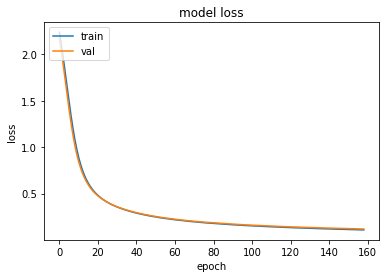

In [ ]:
NN_loss_evaluator(hist)

##### **Constant learning rate, `batch_size = 32`, gaussed**

In [ ]:
neural_net = neural(px = az, py = az, hidden = 1, nodes = [128])
hist = neural_net.fit(td_HOG_train_Gauss, y_train, epochs = 500, batch_size = 32, validation_data=(td_HOG_val_Gauss, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 1s 6ms/step - loss: 2.3309 - accuracy: 0.1063 - val_loss: 2.3251 - val_accuracy: 0.0980
Epoch 2/500
110/110 [==============================] - 0s 4ms/step - loss: 2.3085 - accuracy: 0.1231 - val_loss: 2.3029 - val_accuracy: 0.1140
Epoch 3/500
110/110 [==============================] - 0s 4ms/step - loss: 2.2864 - accuracy: 0.1411 - val_loss: 2.2808 - val_accuracy: 0.1340
Epoch 4/500
110/110 [==============================] - 0s 4ms/step - loss: 2.2645 - accuracy: 0.1651 - val_loss: 2.2590 - val_accuracy: 0.1700
Epoch 5/500
110/110 [==============================] - 0s 4ms/step - loss: 2.2427 - accuracy: 0.1946 - val_loss: 2.2372 - val_accuracy: 0.1980
Epoch 6/500
110/110 [==============================] - 0s 4ms/step - loss: 2.2210 - accuracy: 0.2334 - val_loss: 2.2154 - val_accuracy: 0.2480
Epoch 7/500
110/110 [==============================] - 0s 4ms/step - loss: 2.1991 - accuracy: 0.2886 - val_loss: 2.1935 - val_accuracy: 0.3000

32/32 [==============================] - 0s 2ms/step
number of misclassified datapoints = 61; accuracy = 0.9390000000000001


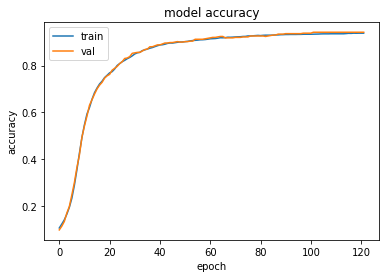

In [ ]:
NN_evaluator(neural_net, hist, td_HOG_test_Gauss, y_test)

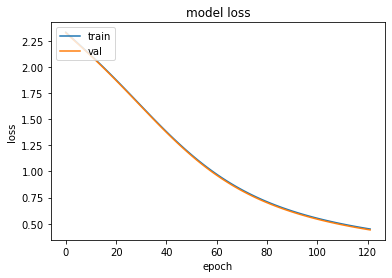

In [ ]:
NN_loss_evaluator(hist)

Let us try once a `batch size = 64` and a `learning rate = 0.01` since the HOG processed data performs so well.

##### **Constant (increased) learning rate, `batch_size = 64`, non gaussed**

In [ ]:
neural_net = neural(px = az, py = az, hidden = 1, nodes = [128], lr = 0.01)
hist = neural_net.fit(td_HOG_train, y_train, epochs = 500, batch_size = 64, validation_data=(td_HOG_val, y_val), callbacks = callbacks_list)

Epoch 1/500
55/55 [==============================] - 1s 9ms/step - loss: 2.2846 - accuracy: 0.1400 - val_loss: 2.2338 - val_accuracy: 0.2380
Epoch 2/500
55/55 [==============================] - 0s 5ms/step - loss: 2.1996 - accuracy: 0.3123 - val_loss: 2.1505 - val_accuracy: 0.4260
Epoch 3/500
55/55 [==============================] - 0s 5ms/step - loss: 2.1151 - accuracy: 0.5083 - val_loss: 2.0644 - val_accuracy: 0.6160
Epoch 4/500
55/55 [==============================] - 0s 5ms/step - loss: 2.0264 - accuracy: 0.6689 - val_loss: 1.9730 - val_accuracy: 0.7240
Epoch 5/500
55/55 [==============================] - 0s 5ms/step - loss: 1.9330 - accuracy: 0.7474 - val_loss: 1.8771 - val_accuracy: 0.7680
Epoch 6/500
55/55 [==============================] - 0s 5ms/step - loss: 1.8344 - accuracy: 0.7711 - val_loss: 1.7774 - val_accuracy: 0.7780
Epoch 7/500
55/55 [==============================] - 0s 5ms/step - loss: 1.7328 - accuracy: 0.7989 - val_loss: 1.6756 - val_accuracy: 0.7940
Epoch 8/500
5

32/32 [==============================] - 0s 4ms/step
number of misclassified datapoints = 46; accuracy = 0.954


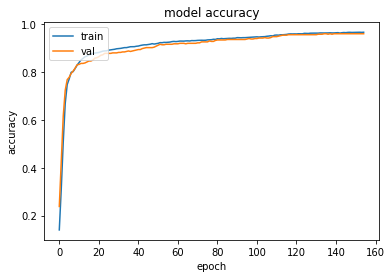

In [ ]:
NN_evaluator(neural_net, hist, td_HOG_test, y_test)

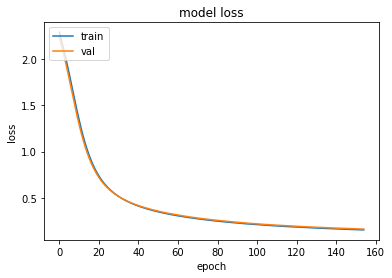

In [ ]:
NN_loss_evaluator(hist)

The model does not seem prone to over fitting. As commonly done in academia (Karpathy, 2019), let us try forcing overfitting without Early Stopping and prune/reduce epochs if necessary.

Is is also worth noting that the orthodox bias-variance tradeoff has been seen to wane off in overparametrized neural networks thanks to a phenomenon called double descent.

In [ ]:
neural_net = neural(px = az, py = az, hidden = 1, nodes = [128], lr = 0.05)
hist = neural_net.fit(td_HOG_train, y_train, epochs = 500, batch_size = 64, validation_data=(td_HOG_val, y_val))

Epoch 1/500
55/55 [==============================] - 1s 9ms/step - loss: 2.0847 - accuracy: 0.4351 - val_loss: 1.8552 - val_accuracy: 0.6480
Epoch 2/500
55/55 [==============================] - 0s 5ms/step - loss: 1.6129 - accuracy: 0.7374 - val_loss: 1.3844 - val_accuracy: 0.7660
Epoch 3/500
55/55 [==============================] - 0s 5ms/step - loss: 1.1799 - accuracy: 0.8306 - val_loss: 1.0101 - val_accuracy: 0.8360
Epoch 4/500
55/55 [==============================] - 0s 5ms/step - loss: 0.8739 - accuracy: 0.8737 - val_loss: 0.7714 - val_accuracy: 0.8620
Epoch 5/500
55/55 [==============================] - 0s 5ms/step - loss: 0.6850 - accuracy: 0.8849 - val_loss: 0.6321 - val_accuracy: 0.8600
Epoch 6/500
55/55 [==============================] - 0s 5ms/step - loss: 0.5691 - accuracy: 0.8940 - val_loss: 0.5381 - val_accuracy: 0.8800
Epoch 7/500
55/55 [==============================] - 0s 5ms/step - loss: 0.4934 - accuracy: 0.9017 - val_loss: 0.4790 - val_accuracy: 0.8940
Epoch 8/500
5

32/32 [==============================] - 0s 2ms/step
number of misclassified datapoints = 13; accuracy = 0.987


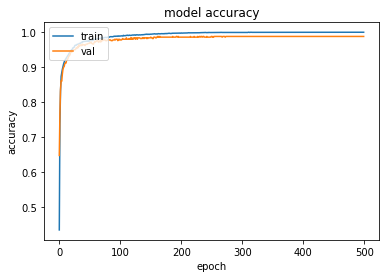

In [ ]:
NN_evaluator(neural_net, hist, td_HOG_test, y_test)

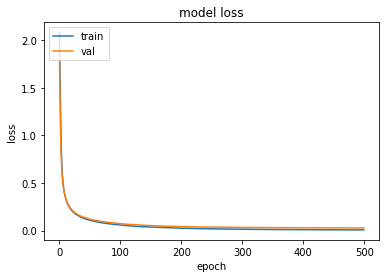

In [ ]:
NN_loss_evaluator(hist)

As per hypothesis, the model does not overfit and keeps improving accuracy. Overparametrizing may lead to even higher accuracy, which I will test later.

The model behaves well with HOG processed data, I am able to train it with `batch_size = 64` and attain comparable accuracies at way faster runtime than any other method.

### **Step 3) Gabor processed data**

**Constant learning rate, non gaussed**

In [ ]:
neural_net = neural(hidden = 1, nodes = [128], lr = 0.001)
hist = neural_net.fit(X_train_Gabor, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_Gabor, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 1s 7ms/step - loss: 2.3254 - accuracy: 0.0971 - val_loss: 2.3012 - val_accuracy: 0.0900
Epoch 2/500
110/110 [==============================] - 1s 5ms/step - loss: 2.2882 - accuracy: 0.1189 - val_loss: 2.2821 - val_accuracy: 0.1340
Epoch 3/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2686 - accuracy: 0.1449 - val_loss: 2.2973 - val_accuracy: 0.0980
Epoch 4/500
110/110 [==============================] - 1s 5ms/step - loss: 2.2547 - accuracy: 0.1634 - val_loss: 2.2442 - val_accuracy: 0.1760
Epoch 5/500
110/110 [==============================] - 1s 5ms/step - loss: 2.2379 - accuracy: 0.1809 - val_loss: 2.2340 - val_accuracy: 0.1240
Epoch 6/500
110/110 [==============================] - 1s 5ms/step - loss: 2.2210 - accuracy: 0.2191 - val_loss: 2.2143 - val_accuracy: 0.1960
Epoch 7/500
110/110 [==============================] - 1s 5ms/step - loss: 2.2039 - accuracy: 0.2491 - val_loss: 2.2224 - val_accuracy: 0.2220

32/32 [==============================] - 0s 3ms/step
number of misclassified datapoints = 118; accuracy = 0.882


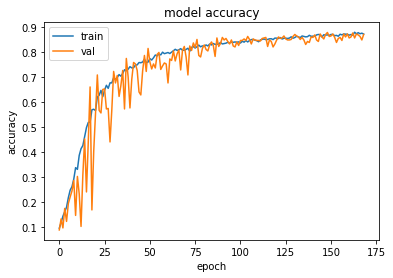

In [ ]:
NN_evaluator(neural_net, hist, X_test_Gabor, y_test)

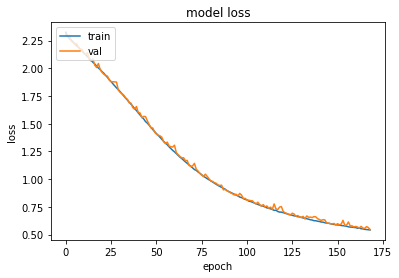

In [ ]:
NN_loss_evaluator(hist)

###### **Constant learning rate, gaussed**

In [ ]:
neural_net = neural(hidden = 1, nodes = [128])
hist = neural_net.fit(X_train_Gabor_Gauss, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_Gabor_Gauss, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 1s 7ms/step - loss: 2.3109 - accuracy: 0.1377 - val_loss: 2.2899 - val_accuracy: 0.1200
Epoch 2/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2668 - accuracy: 0.1669 - val_loss: 2.2729 - val_accuracy: 0.1160
Epoch 3/500
110/110 [==============================] - 1s 5ms/step - loss: 2.2472 - accuracy: 0.1791 - val_loss: 2.2705 - val_accuracy: 0.0940
Epoch 4/500
110/110 [==============================] - 1s 5ms/step - loss: 2.2325 - accuracy: 0.2054 - val_loss: 2.2278 - val_accuracy: 0.2260
Epoch 5/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2151 - accuracy: 0.2217 - val_loss: 2.2133 - val_accuracy: 0.1840
Epoch 6/500
110/110 [==============================] - 1s 5ms/step - loss: 2.1967 - accuracy: 0.2494 - val_loss: 2.1995 - val_accuracy: 0.2460
Epoch 7/500
110/110 [==============================] - 1s 5ms/step - loss: 2.1790 - accuracy: 0.3114 - val_loss: 2.1955 - val_accuracy: 0.1300

32/32 [==============================] - 0s 2ms/step
number of misclassified datapoints = 155; accuracy = 0.845


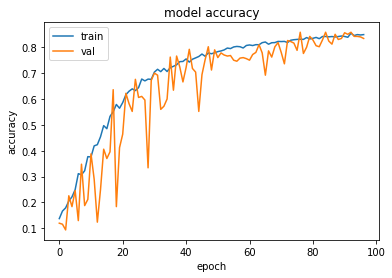

In [ ]:
NN_evaluator(neural_net, hist, X_test_Gabor_Gauss, y_test)

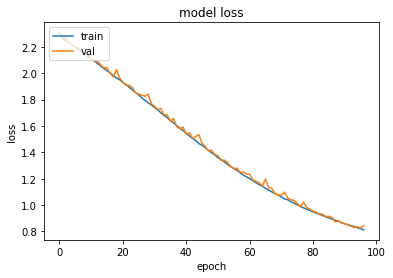

In [ ]:
NN_loss_evaluator(hist)

Fluctuation is pretty strong at the beginning although it settles going forward.

Increasing the learning rate could result in better performance. To test the model, I am gonna drop EarlyStopping in this experiment.

###### **Constant rate, non gaussed, unrestricted**

In [ ]:
neural_net = neural(hidden = 1, nodes = [128], lr = 0.005)
hist = neural_net.fit(X_train_Gabor, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_Gabor, y_val))

Epoch 1/500
110/110 [==============================] - 3s 7ms/step - loss: 2.3230 - accuracy: 0.1140 - val_loss: 2.3303 - val_accuracy: 0.1020
Epoch 2/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2558 - accuracy: 0.1591 - val_loss: 2.2477 - val_accuracy: 0.1260
Epoch 3/500
110/110 [==============================] - 1s 5ms/step - loss: 2.1997 - accuracy: 0.2089 - val_loss: 2.4072 - val_accuracy: 0.0920
Epoch 4/500
110/110 [==============================] - 1s 7ms/step - loss: 2.1460 - accuracy: 0.2414 - val_loss: 2.1015 - val_accuracy: 0.3120
Epoch 5/500
110/110 [==============================] - 1s 8ms/step - loss: 2.0894 - accuracy: 0.2960 - val_loss: 2.0689 - val_accuracy: 0.3820
Epoch 6/500
110/110 [==============================] - 1s 8ms/step - loss: 2.0202 - accuracy: 0.3506 - val_loss: 1.9725 - val_accuracy: 0.5120
Epoch 7/500
110/110 [==============================] - 1s 8ms/step - loss: 1.9590 - accuracy: 0.3991 - val_loss: 1.9932 - val_accuracy: 0.4140

32/32 [==============================] - 0s 6ms/step
number of misclassified datapoints = 71; accuracy = 0.929


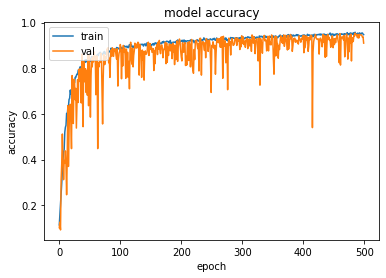

In [ ]:
NN_evaluator(neural_net, hist, X_test_Gabor, y_test)

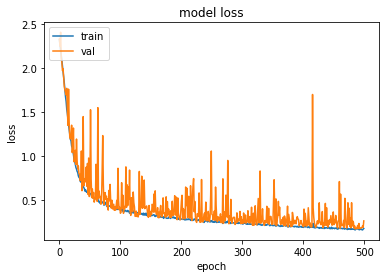

In [ ]:
NN_loss_evaluator(hist)

##### **Second method: learning rate decay, non gaussed, unrestricted**

In [ ]:
initial_learning_rate = 0.005
epochs = 500
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

model = neural(hidden = 1, nodes = [128], lr = initial_learning_rate)
callback = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=1)

history_time_based_decay = model.fit(
    X_train_Gabor, 
    y_train, 
    epochs=500, 
    validation_data=(X_val_Gabor, y_val),
    batch_size=32,
    callbacks=[callback],
    verbose = 1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/500
110/110 [==============================] - 1s 7ms/step - loss: 2.3123 - accuracy: 0.1346 - val_loss: 2.4202 - val_accuracy: 0.1020 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999899890243487.
Epoch 2/500
110/110 [==============================] - 1s 5ms/step - loss: 2.2352 - accuracy: 0.1591 - val_loss: 2.4625 - val_accuracy: 0.1180 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999699783073196.
Epoch 3/500
110/110 [==============================] - 1s 5ms/step - loss: 2.1876 - accuracy: 0.1997 - val_loss: 2.3358 - val_accuracy: 0.1760 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.004999400038369963.
Epoch 4/500
110/110 [==============================] - 1s 5ms/step - loss: 2.1249 - accuracy: 0.2469 - val_loss: 2.1015 - val_accuracy: 0.1720 - lr: 0.0050

Epoch 5: LearningRateScheduler setting learning rate to 0.0

32/32 [==============================] - 0s 2ms/step
number of misclassified datapoints = 71; accuracy = 0.929


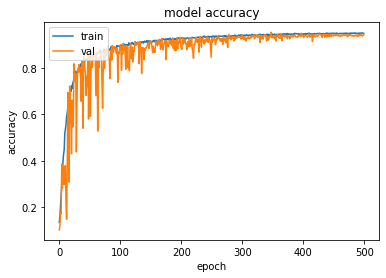

In [ ]:
NN_evaluator(model, history_time_based_decay, X_test_Gabor, y_test)

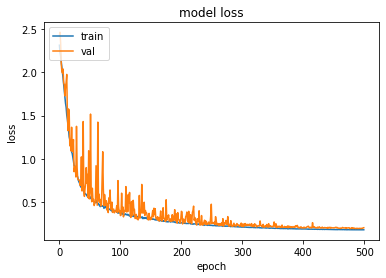

In [ ]:
NN_loss_evaluator(history_time_based_decay)

Although much of the oscillation has disappeared, the performance does not benefit from this treatment, showing how differences in parameters around the minima are negligible.

### **Step 4)LBPH data**

In [ ]:
ax,ay = X_train_LBPH.shape 
td_LBPH_train = X_train_LBPH.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))
td_LBPH_train_Gauss = X_train_LBPH_Gauss.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))

ax,ay = X_val_LBPH.shape
td_LBPH_val = X_val_LBPH.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))
td_LBPH_val_Gauss = X_val_LBPH_Gauss.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))

ax,ay = X_test_LBPH.shape
td_LBPH_test = X_test_LBPH.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))
td_LBPH_test_Gauss = X_test_LBPH_Gauss.reshape(ax,int(np.sqrt(ay)),int(np.sqrt(ay)))

ax,ay,az = td_LBPH_train.shape

neural_net = neural(px = az, py = az, hidden = 1, nodes = [128], lr = 0.01)
hist = neural_net.fit(td_LBPH_train, y_train, epochs = 500, batch_size = 32, validation_data=(td_LBPH_val, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 2.2787 - accuracy: 0.1623 - val_loss: 2.2398 - val_accuracy: 0.3160
Epoch 2/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2003 - accuracy: 0.3909 - val_loss: 2.1656 - val_accuracy: 0.4680
Epoch 3/500
110/110 [==============================] - 1s 6ms/step - loss: 2.1213 - accuracy: 0.5103 - val_loss: 2.0874 - val_accuracy: 0.5060
Epoch 4/500
110/110 [==============================] - 1s 6ms/step - loss: 2.0374 - accuracy: 0.5620 - val_loss: 2.0004 - val_accuracy: 0.5920
Epoch 5/500
110/110 [==============================] - 1s 6ms/step - loss: 1.9467 - accuracy: 0.6226 - val_loss: 1.9081 - val_accuracy: 0.5920
Epoch 6/500
110/110 [==============================] - 1s 6ms/step - loss: 1.8502 - accuracy: 0.6391 - val_loss: 1.8107 - val_accuracy: 0.6220
Epoch 7/500
110/110 [==============================] - 1s 5ms/step - loss: 1.7518 - accuracy: 0.6649 - val_loss: 1.7152 - val_accuracy: 0.6340

32/32 [==============================] - 0s 3ms/step
number of misclassified datapoints = 95; accuracy = 0.905


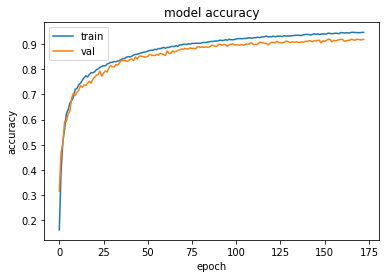

In [ ]:
NN_evaluator(neural_net, hist, td_LBPH_test, y_test)

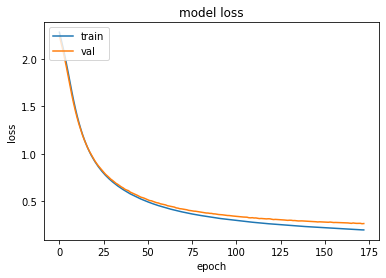

In [ ]:
NN_loss_evaluator(hist)

In [ ]:
neural_net = neural(px = az, py = az, hidden = 1, nodes = [128], lr = 0.01)
hist = neural_net.fit(td_LBPH_train_Gauss, y_train, epochs = 500, batch_size = 32, validation_data=(td_LBPH_val_Gauss, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 9ms/step - loss: 2.2665 - accuracy: 0.1769 - val_loss: 2.2119 - val_accuracy: 0.3040
Epoch 2/500
110/110 [==============================] - 1s 6ms/step - loss: 2.1659 - accuracy: 0.3991 - val_loss: 2.1123 - val_accuracy: 0.5160
Epoch 3/500
110/110 [==============================] - 1s 6ms/step - loss: 2.0668 - accuracy: 0.5720 - val_loss: 2.0069 - val_accuracy: 0.6160
Epoch 4/500
110/110 [==============================] - 1s 5ms/step - loss: 1.9623 - accuracy: 0.6569 - val_loss: 1.8940 - val_accuracy: 0.7160
Epoch 5/500
110/110 [==============================] - 0s 4ms/step - loss: 1.8544 - accuracy: 0.7271 - val_loss: 1.7824 - val_accuracy: 0.7420
Epoch 6/500
110/110 [==============================] - 0s 4ms/step - loss: 1.7458 - accuracy: 0.7586 - val_loss: 1.6723 - val_accuracy: 0.7860
Epoch 7/500
110/110 [==============================] - 0s 4ms/step - loss: 1.6391 - accuracy: 0.8011 - val_loss: 1.5679 - val_accuracy: 0.8020

32/32 [==============================] - 0s 3ms/step
number of misclassified datapoints = 44; accuracy = 0.956


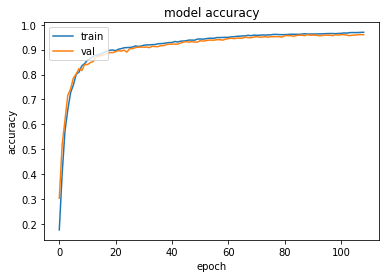

In [ ]:
NN_evaluator(neural_net, hist, td_LBPH_test_Gauss, y_test)

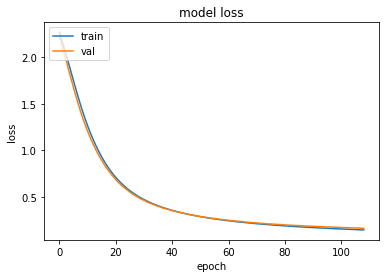

In [ ]:
NN_loss_evaluator(hist)

### **Step 5) Increasing complexity**

Since on average constant learning rate has outperformed decay learning rate, I will disregard calculations about the latter from now on.

###### **Constant learning rate, non gaussed**

In [ ]:
neural_net = neural(hidden = 3, nodes = [128, 128, 128], lr = 0.003)
hist = neural_net.fit(X_train, y_train,
                      epochs = 500,
                      batch_size = 32,
                      validation_data=(X_val, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 51s 9ms/step - loss: 2.2893 - accuracy: 0.1409 - val_loss: 2.2581 - val_accuracy: 0.1800
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 2.2232 - accuracy: 0.2280 - val_loss: 2.2216 - val_accuracy: 0.1520
Epoch 3/500
110/110 [==============================] - 1s 6ms/step - loss: 2.1765 - accuracy: 0.2734 - val_loss: 2.1877 - val_accuracy: 0.1700
Epoch 4/500
110/110 [==============================] - 1s 6ms/step - loss: 2.1198 - accuracy: 0.3231 - val_loss: 2.0944 - val_accuracy: 0.2860
Epoch 5/500
110/110 [==============================] - 1s 6ms/step - loss: 2.0498 - accuracy: 0.3617 - val_loss: 2.0128 - val_accuracy: 0.3780
Epoch 6/500
110/110 [==============================] - 1s 6ms/step - loss: 1.9640 - accuracy: 0.3957 - val_loss: 1.9192 - val_accuracy: 0.4780
Epoch 7/500
110/110 [==============================] - 1s 6ms/step - loss: 1.8752 - accuracy: 0.4449 - val_loss: 1.8862 - val_accuracy: 0.390

32/32 [==============================] - 0s 3ms/step
number of misclassified datapoints = 51; accuracy = 0.949


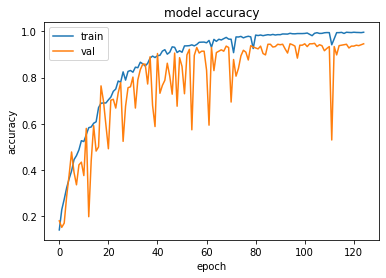

In [ ]:
NN_evaluator(neural_net, hist, X_test, y_test)

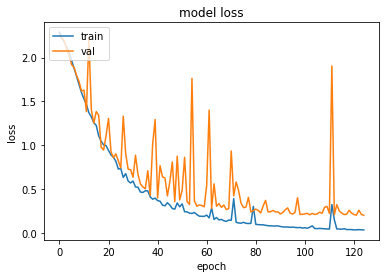

In [ ]:
NN_loss_evaluator(hist)

###### **Constant learning rate, gaussed**

In [ ]:
neural_net = neural(hidden = 3, nodes = [128,128, 128], lr = 0.001)
hist = neural_net.fit(X_train_Gauss, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_Gauss, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 9ms/step - loss: 2.3091 - accuracy: 0.1271 - val_loss: 2.2849 - val_accuracy: 0.1320
Epoch 2/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2781 - accuracy: 0.1766 - val_loss: 2.2746 - val_accuracy: 0.2080
Epoch 3/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2670 - accuracy: 0.2003 - val_loss: 2.2774 - val_accuracy: 0.1620
Epoch 4/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2588 - accuracy: 0.2260 - val_loss: 2.2587 - val_accuracy: 0.2020
Epoch 5/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2497 - accuracy: 0.2380 - val_loss: 2.2476 - val_accuracy: 0.2500
Epoch 6/500
110/110 [==============================] - 1s 9ms/step - loss: 2.2382 - accuracy: 0.2486 - val_loss: 2.2415 - val_accuracy: 0.2540
Epoch 7/500
110/110 [==============================] - 1s 10ms/step - loss: 2.2280 - accuracy: 0.2966 - val_loss: 2.2330 - val_accuracy: 0.262

32/32 [==============================] - 0s 3ms/step
number of misclassified datapoints = 111; accuracy = 0.889


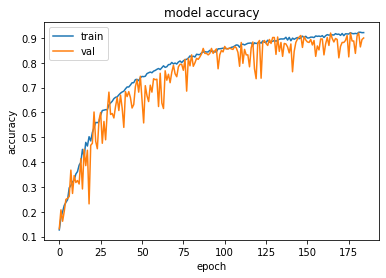

In [ ]:
NN_evaluator(neural_net, hist, X_test_Gauss, y_test)

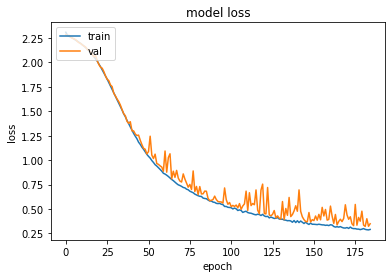

In [ ]:
NN_loss_evaluator(hist)

### **LBP Processed data**

###### **Constant learning rate, non gaussed, OVERFITTING!**

In [ ]:
neural_net = neural(hidden = 3, nodes = [128,128,128], lr = 0.005)
hist = neural_net.fit(X_train_LBP, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_LBP, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 12ms/step - loss: 2.9039 - accuracy: 0.1306 - val_loss: 2.2503 - val_accuracy: 0.1720
Epoch 2/500
110/110 [==============================] - 1s 9ms/step - loss: 2.2342 - accuracy: 0.1789 - val_loss: 2.4379 - val_accuracy: 0.1060
Epoch 3/500
110/110 [==============================] - 1s 9ms/step - loss: 2.1436 - accuracy: 0.2177 - val_loss: 2.7268 - val_accuracy: 0.1680
Epoch 4/500
110/110 [==============================] - 1s 8ms/step - loss: 2.1000 - accuracy: 0.2466 - val_loss: 2.3616 - val_accuracy: 0.2060
Epoch 5/500
110/110 [==============================] - 1s 6ms/step - loss: 1.9956 - accuracy: 0.2929 - val_loss: 2.6261 - val_accuracy: 0.1880
Epoch 6/500
110/110 [==============================] - 1s 6ms/step - loss: 1.9203 - accuracy: 0.3191 - val_loss: 1.6107 - val_accuracy: 0.4500
Epoch 7/500
110/110 [==============================] - 1s 8ms/step - loss: 1.8297 - accuracy: 0.3603 - val_loss: 1.8183 - val_accuracy: 0.230

32/32 [==============================] - 0s 4ms/step
number of misclassified datapoints = 179; accuracy = 0.821


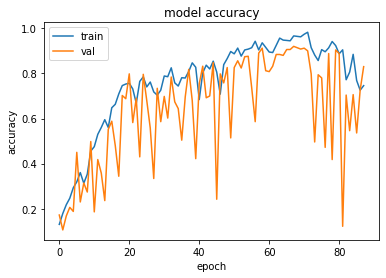

In [ ]:
NN_evaluator(neural_net, hist, X_test_LBP, y_test)

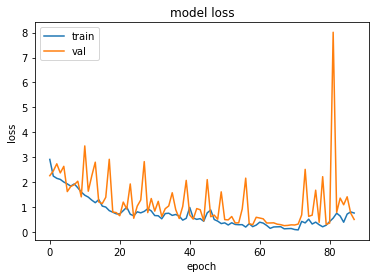

In [ ]:
NN_loss_evaluator(hist)

Maybe implementing `momentum` might help:

In [ ]:
neural_net = neural(hidden = 3, nodes = [128,128,128], lr = 0.001, momentum = 0.5)
hist = neural_net.fit(X_train_LBP, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_LBP, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 10ms/step - loss: 2.3729 - accuracy: 0.1986 - val_loss: 2.1674 - val_accuracy: 0.1620
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 1.9450 - accuracy: 0.3114 - val_loss: 2.3137 - val_accuracy: 0.1760
Epoch 3/500
110/110 [==============================] - 1s 7ms/step - loss: 1.7162 - accuracy: 0.3914 - val_loss: 4.1932 - val_accuracy: 0.1060
Epoch 4/500
110/110 [==============================] - 1s 7ms/step - loss: 1.5581 - accuracy: 0.4766 - val_loss: 1.3860 - val_accuracy: 0.5080
Epoch 5/500
110/110 [==============================] - 1s 8ms/step - loss: 1.3085 - accuracy: 0.5589 - val_loss: 1.1781 - val_accuracy: 0.5840
Epoch 6/500
110/110 [==============================] - 1s 7ms/step - loss: 1.1161 - accuracy: 0.6254 - val_loss: 1.8280 - val_accuracy: 0.3960
Epoch 7/500
110/110 [==============================] - 1s 7ms/step - loss: 1.0017 - accuracy: 0.6554 - val_loss: 0.9302 - val_accuracy: 0.692

32/32 [==============================] - 0s 4ms/step
number of misclassified datapoints = 73; accuracy = 0.927


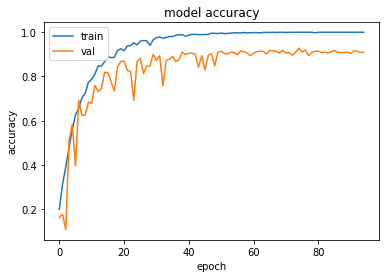

In [ ]:
NN_evaluator(neural_net, hist, X_test_LBP, y_test)

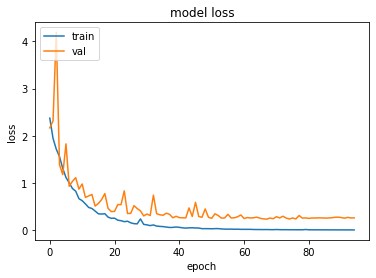

In [ ]:
NN_loss_evaluator(hist)

###### **Constant learning rate, gaussed**

In [ ]:
neural_net = neural(hidden = 3, nodes = [128,128, 128], lr = 0.001)
hist = neural_net.fit(X_train_LBP_Gauss, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_LBP_Gauss, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 9ms/step - loss: 1.8324 - accuracy: 0.4003 - val_loss: 1.4190 - val_accuracy: 0.4980
Epoch 2/500
110/110 [==============================] - 1s 6ms/step - loss: 1.0051 - accuracy: 0.6549 - val_loss: 1.7865 - val_accuracy: 0.3780
Epoch 3/500
110/110 [==============================] - 1s 6ms/step - loss: 0.7883 - accuracy: 0.7300 - val_loss: 1.0169 - val_accuracy: 0.6080
Epoch 4/500
110/110 [==============================] - 1s 6ms/step - loss: 0.6454 - accuracy: 0.7786 - val_loss: 0.7241 - val_accuracy: 0.7220
Epoch 5/500
110/110 [==============================] - 1s 6ms/step - loss: 0.5579 - accuracy: 0.8071 - val_loss: 0.6032 - val_accuracy: 0.7720
Epoch 6/500
110/110 [==============================] - 1s 6ms/step - loss: 0.5097 - accuracy: 0.8194 - val_loss: 0.4865 - val_accuracy: 0.8240
Epoch 7/500
110/110 [==============================] - 1s 6ms/step - loss: 0.4666 - accuracy: 0.8446 - val_loss: 0.4941 - val_accuracy: 0.8200

32/32 [==============================] - 0s 3ms/step
number of misclassified datapoints = 63; accuracy = 0.937


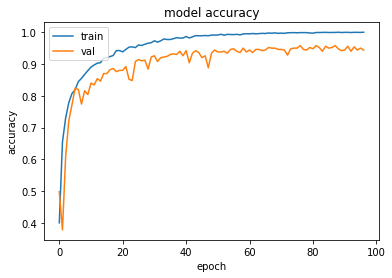

In [ ]:
NN_evaluator(neural_net, hist, X_test_LBP_Gauss, y_test)

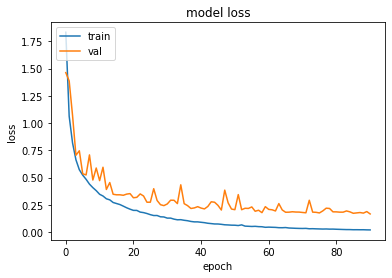

In [ ]:
NN_loss_evaluator(hist)

### **HOG Processed data**

###### **Constant learning rate, non gaussed**

In [ ]:
neural_net = neural(px = az, py = az, hidden = 3, nodes = [128, 128, 128], lr = 0.01)
hist = neural_net.fit(td_HOG_train, y_train, epochs = 500, batch_size = 64, validation_data=(td_HOG_val, y_val), callbacks = callbacks_list)

Epoch 1/500
55/55 [==============================] - 2s 16ms/step - loss: 2.2946 - accuracy: 0.1100 - val_loss: 2.2822 - val_accuracy: 0.1620
Epoch 2/500
55/55 [==============================] - 1s 9ms/step - loss: 2.2655 - accuracy: 0.2434 - val_loss: 2.2524 - val_accuracy: 0.3060
Epoch 3/500
55/55 [==============================] - 1s 10ms/step - loss: 2.2328 - accuracy: 0.4051 - val_loss: 2.2176 - val_accuracy: 0.4560
Epoch 4/500
55/55 [==============================] - 0s 6ms/step - loss: 2.1926 - accuracy: 0.5260 - val_loss: 2.1741 - val_accuracy: 0.5620
Epoch 5/500
55/55 [==============================] - 0s 8ms/step - loss: 2.1414 - accuracy: 0.6091 - val_loss: 2.1178 - val_accuracy: 0.6080
Epoch 6/500
55/55 [==============================] - 0s 8ms/step - loss: 2.0744 - accuracy: 0.6351 - val_loss: 2.0430 - val_accuracy: 0.6400
Epoch 7/500
55/55 [==============================] - 0s 7ms/step - loss: 1.9862 - accuracy: 0.6766 - val_loss: 1.9446 - val_accuracy: 0.6680
Epoch 8/500

32/32 [==============================] - 0s 3ms/step
number of misclassified datapoints = 35; accuracy = 0.965


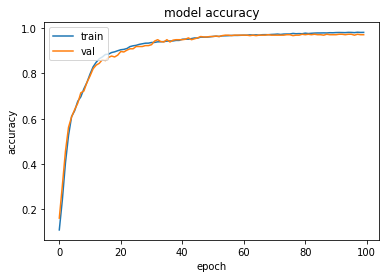

In [ ]:
NN_evaluator(neural_net, hist, td_HOG_test, y_test)

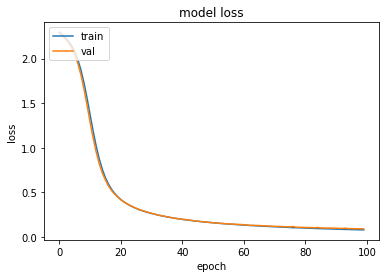

In [ ]:
NN_loss_evaluator(hist)

###### **Constant learning rate, gaussed**

In [ ]:
neural_net = neural(px = az, py = az, hidden = 3, nodes = [128, 128, 128], lr = 0.01)
hist = neural_net.fit(td_HOG_train_Gauss, y_train, epochs = 500, batch_size = 32, validation_data=(td_HOG_val_Gauss, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 6ms/step - loss: 2.2818 - accuracy: 0.1657 - val_loss: 2.2521 - val_accuracy: 0.3160
Epoch 2/500
110/110 [==============================] - 1s 5ms/step - loss: 2.2217 - accuracy: 0.3991 - val_loss: 2.1791 - val_accuracy: 0.4860
Epoch 3/500
110/110 [==============================] - 1s 5ms/step - loss: 2.1270 - accuracy: 0.5620 - val_loss: 2.0524 - val_accuracy: 0.6060
Epoch 4/500
110/110 [==============================] - 1s 5ms/step - loss: 1.9596 - accuracy: 0.6469 - val_loss: 1.8308 - val_accuracy: 0.6760
Epoch 5/500
110/110 [==============================] - 0s 4ms/step - loss: 1.6806 - accuracy: 0.7369 - val_loss: 1.4935 - val_accuracy: 0.7340
Epoch 6/500
110/110 [==============================] - 0s 4ms/step - loss: 1.3061 - accuracy: 0.8031 - val_loss: 1.0998 - val_accuracy: 0.8540
Epoch 7/500
110/110 [==============================] - 1s 5ms/step - loss: 0.9393 - accuracy: 0.8806 - val_loss: 0.7713 - val_accuracy: 0.8960

32/32 [==============================] - 0s 2ms/step
number of misclassified datapoints = 10; accuracy = 0.99


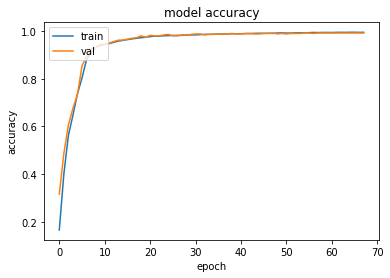

In [ ]:
NN_evaluator(neural_net, hist, td_HOG_test_Gauss, y_test)

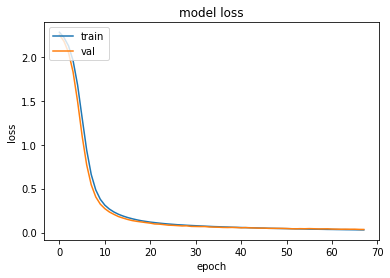

In [ ]:
NN_loss_evaluator(hist)

### **Gabor Processed data**

###### **Constant learning rate, non gaussed**

In [ ]:
neural_net = neural(hidden = 3, nodes = [128,128, 128], lr = 0.001)
hist = neural_net.fit(X_train_Gabor, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_Gabor, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 9ms/step - loss: 2.3126 - accuracy: 0.0891 - val_loss: 2.2857 - val_accuracy: 0.0920
Epoch 2/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2782 - accuracy: 0.1640 - val_loss: 2.2769 - val_accuracy: 0.1280
Epoch 3/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2684 - accuracy: 0.1811 - val_loss: 2.2758 - val_accuracy: 0.1800
Epoch 4/500
110/110 [==============================] - 1s 8ms/step - loss: 2.2621 - accuracy: 0.2086 - val_loss: 2.2677 - val_accuracy: 0.1520
Epoch 5/500
110/110 [==============================] - 1s 10ms/step - loss: 2.2559 - accuracy: 0.2311 - val_loss: 2.2570 - val_accuracy: 0.2340
Epoch 6/500
110/110 [==============================] - 1s 10ms/step - loss: 2.2487 - accuracy: 0.2089 - val_loss: 2.2501 - val_accuracy: 0.2480
Epoch 7/500
110/110 [==============================] - 1s 9ms/step - loss: 2.2417 - accuracy: 0.2877 - val_loss: 2.2501 - val_accuracy: 0.24

32/32 [==============================] - 0s 3ms/step
number of misclassified datapoints = 133; accuracy = 0.867


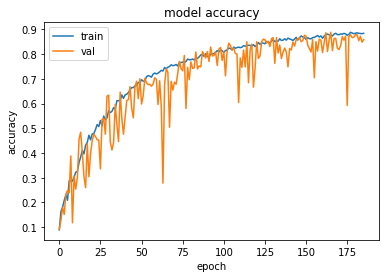

In [ ]:
NN_evaluator(neural_net, hist, X_test_Gabor, y_test)

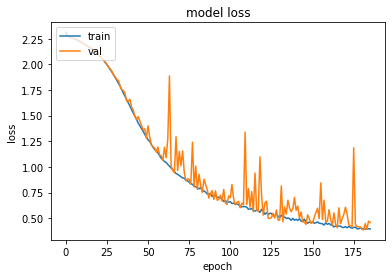

In [ ]:
NN_loss_evaluator(hist)

###### **Constant learning rate, gaussed**

In [ ]:
neural_net = neural(hidden = 3, nodes = [128, 128, 128])
hist = neural_net.fit(X_train_Gabor_Gauss, y_train, epochs = 500, batch_size = 32, validation_data=(X_val_Gabor_Gauss, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 9ms/step - loss: 2.2978 - accuracy: 0.1340 - val_loss: 2.2841 - val_accuracy: 0.1300
Epoch 2/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2760 - accuracy: 0.1580 - val_loss: 2.2738 - val_accuracy: 0.2240
Epoch 3/500
110/110 [==============================] - 1s 7ms/step - loss: 2.2660 - accuracy: 0.1957 - val_loss: 2.2735 - val_accuracy: 0.1860
Epoch 4/500
110/110 [==============================] - 1s 6ms/step - loss: 2.2591 - accuracy: 0.2011 - val_loss: 2.2531 - val_accuracy: 0.2960
Epoch 5/500
110/110 [==============================] - 1s 8ms/step - loss: 2.2521 - accuracy: 0.2289 - val_loss: 2.2554 - val_accuracy: 0.1940
Epoch 6/500
110/110 [==============================] - 1s 10ms/step - loss: 2.2431 - accuracy: 0.2194 - val_loss: 2.2452 - val_accuracy: 0.3040
Epoch 7/500
110/110 [==============================] - 2s 15ms/step - loss: 2.2345 - accuracy: 0.2874 - val_loss: 2.2367 - val_accuracy: 0.29

32/32 [==============================] - 0s 3ms/step
number of misclassified datapoints = 142; accuracy = 0.858


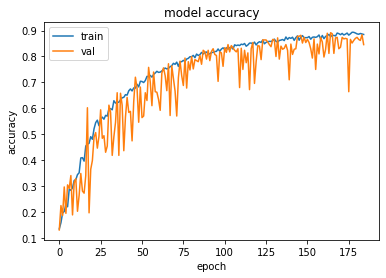

In [ ]:
NN_evaluator(neural_net, hist, X_test_Gabor_Gauss, y_test)

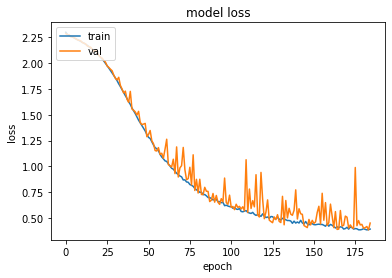

In [ ]:
NN_loss_evaluator(hist)

### **LBPH Processed data**

###### **Constant learning rate, non gaussed**

In [ ]:
neural_net = neural(px = az, py = az, hidden = 3, nodes = [128,128, 128], lr = 0.01)
hist = neural_net.fit(td_LBPH_train, y_train, epochs = 500, batch_size = 32, validation_data=(td_LBPH_val, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 2s 12ms/step - loss: 2.2829 - accuracy: 0.1686 - val_loss: 2.2667 - val_accuracy: 0.2900
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 2.2438 - accuracy: 0.4020 - val_loss: 2.2254 - val_accuracy: 0.4480
Epoch 3/500
110/110 [==============================] - 1s 7ms/step - loss: 2.1926 - accuracy: 0.4951 - val_loss: 2.1658 - val_accuracy: 0.4880
Epoch 4/500
110/110 [==============================] - 2s 15ms/step - loss: 2.1177 - accuracy: 0.5177 - val_loss: 2.0743 - val_accuracy: 0.5320
Epoch 5/500
110/110 [==============================] - 1s 7ms/step - loss: 2.0059 - accuracy: 0.5617 - val_loss: 1.9432 - val_accuracy: 0.5080
Epoch 6/500
110/110 [==============================] - 1s 7ms/step - loss: 1.8492 - accuracy: 0.5577 - val_loss: 1.7670 - val_accuracy: 0.5780
Epoch 7/500
110/110 [==============================] - 1s 6ms/step - loss: 1.6618 - accuracy: 0.5966 - val_loss: 1.5744 - val_accuracy: 0.60

32/32 [==============================] - 0s 3ms/step
number of misclassified datapoints = 51; accuracy = 0.949


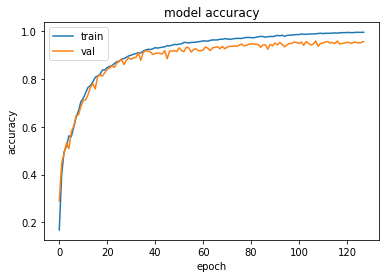

In [ ]:
NN_evaluator(neural_net, hist, td_LBPH_test, y_test)

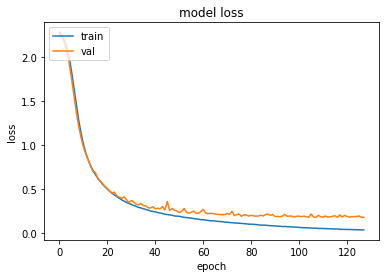

In [ ]:
NN_loss_evaluator(hist)

###### **Constant learning rate, gaussed**

In [ ]:
neural_net = neural(px = az, py = az, hidden = 3, nodes = [128,128,128], lr = 0.01)
hist = neural_net.fit(td_LBPH_train_Gauss, y_train, epochs = 500, batch_size = 32, validation_data=(td_LBPH_val_Gauss, y_val), callbacks = callbacks_list)

Epoch 1/500
110/110 [==============================] - 1s 7ms/step - loss: 2.2796 - accuracy: 0.1946 - val_loss: 2.2529 - val_accuracy: 0.3140
Epoch 2/500
110/110 [==============================] - 1s 5ms/step - loss: 2.2370 - accuracy: 0.3651 - val_loss: 2.2020 - val_accuracy: 0.4240
Epoch 3/500
110/110 [==============================] - 0s 4ms/step - loss: 2.1762 - accuracy: 0.4660 - val_loss: 2.1230 - val_accuracy: 0.4740
Epoch 4/500
110/110 [==============================] - 1s 5ms/step - loss: 2.0850 - accuracy: 0.5374 - val_loss: 1.9997 - val_accuracy: 0.5420
Epoch 5/500
110/110 [==============================] - 0s 4ms/step - loss: 1.9500 - accuracy: 0.5777 - val_loss: 1.8323 - val_accuracy: 0.6400
Epoch 6/500
110/110 [==============================] - 0s 4ms/step - loss: 1.7681 - accuracy: 0.6451 - val_loss: 1.6254 - val_accuracy: 0.7060
Epoch 7/500
110/110 [==============================] - 0s 4ms/step - loss: 1.5607 - accuracy: 0.6889 - val_loss: 1.4233 - val_accuracy: 0.7040

32/32 [==============================] - 0s 2ms/step
number of misclassified datapoints = 19; accuracy = 0.981


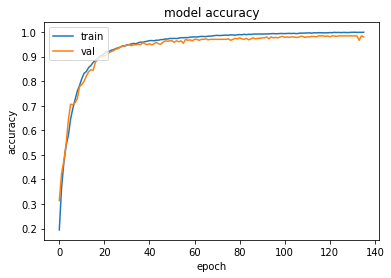

In [ ]:
NN_evaluator(neural_net, hist, td_LBPH_test_Gauss, y_test)

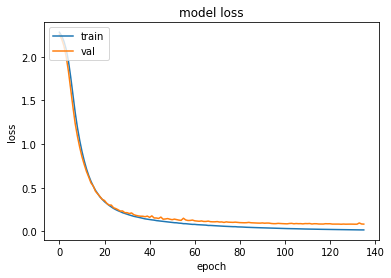

In [ ]:
NN_loss_evaluator(hist)